<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor_FINAL_713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 EM-DRATS (Environment for the Monitoring of Demographics, Retention, Affect, Tolerability, and Stratification)

requires:
Drop out questions_XXX.csv
wp2_post_session_4_XXX.csv
wp2_post_sessions_1-3_XXX.csv
wp2_pre_screen_XXX.csv
wp2_pre_session_1_XXX.csv
wp2_pre_sessions_2-4_XXX.csv
wp2_sms_day1,3,5_XXX.csv
wp2_sms_post_XXX.csv

creates:
wp2_assignments.csv
stratified & blinded sequence name per new participant ID
monitoring of wellbeing & tolerability
monitoring of demographic data, exclusion & retention rate

script 1: sign-up, demographic, retention (not for researcher use -- PI use only)
- run after running script 2 as it requires wp2_assignments

script 2: main blind stratification script (for researcher use)
- requires pre-screen CSV and creates list of blinded sequence names per new successful bookings (calendly_event_booked)
- below it is a stratification balance check, though it exposes number of strata per condition, so may unblind (not for researcher use -- PI use only)
- below the stratification balance check is the fixed seed (=42) through which our 5 control and 5 intervention sequences were renamed -- no need to ever run this again

script 3: main longitudinal wellbeing monitoring per condition/measure (not for researcher use -- PI use only)
- requires all 7 wellbeing CSVs
- plots per measure per condition with "worsening" part_ids outlined in summary tables below each measure plot
- used to see when clinicians should reach out to specific participants (touch base with researcher to link part_id to email)

script 4: main tolerability monitoring per condition (for any use)
- requires all post-session CSVs to make sure that session tolerability never exceeds our specified threshold
- future updates will incorporate FIBSER ratings? unsure

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    """Find exactly one CSV in DATA_DIR whose filename contains substring."""
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}'")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load assignments
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

# Pools of sequence codes for inferring drop‐out arm later
INTERVENTION_SEQS = assign.loc[assign['condition']=='intervention','sequence_name'].unique().tolist()
CONTROL_SEQS      = assign.loc[assign['condition']=='control','sequence_name'].unique().tolist()

#####
# 0.1) Manual‐exclusion & manual‐dropout lists
#####
# IDs who never attended Session 1 at all:
MANUAL_EXCLUDE_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    "11198", # reserved for manual scheduling
    # 11139 reserved for manual scheduling (HAS SCHEDULED!)
    "11382", # requested to withdraw and have data deleted before Session 1
    "11290", # missed Session 1 and never rescheduled
    "11302", # missed Session 1, we'll see if they reschedule
    # 11400 # reserved for manual scheduling (HAS SCHEDULED!)
    "11357", # missed Session 1
    "11379", # missed Session 1
    "11309", # dropout (life events)
    "11393", # missed Session 1 after second rescheduling (previously missed Session 1)
    "11316", # missed Session 1 and never rescheduled
    "11162", # dropped out due to life events after Session 2
    "11153", # dropped out after taster session :(
    # "11296" # never got back in touch after needing to reschedule
    "11296" , # not depressed
    "11254" # manual scheduling ? not in calendar
}

# IDs who did attend Session 1 but later dropped out:
MANUAL_DROPOUT_IDS = {
    "11309", # dropout (life events) after attending Session 1
    "11162", # dropped out after Session 2
    "11153", # dropped out after taster
    "11152" # too sick to make Session 2; will need to re-signup once feeling better
}

# If those drop‐out IDs are no longer in assignments.csv, map them back:
MANUAL_DROPOUT_SEQ = {
    "11309": "WP2-6E363F",
    "11162": "WP2-6E363F",
    "11153": "WP2-3EB089",
    "11151": "WP2-3EB089"
}

#####
# 1) Load & summarize pre-screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre.columns = df_pre.columns.str.strip()

# 1.1) Normalize & drop the phantom ImportId row
if 'part_id' not in df_pre.columns:
    df_pre.rename(columns={df_pre.columns[0]: 'part_id'}, inplace=True)
df_pre['part_id'] = df_pre['part_id'].fillna('').astype(str)
df_pre = df_pre[~df_pre['part_id'].str.contains('ImportId', na=False)].copy()

# 1.2) Keep only “completed” screener runs:
#    – answered final inclusion question (incl_dem_light),
#      OR were routed out early by any safety question
safety_cols = [f'safety_{i}' for i in range(1,8)]
df_pre = df_pre[
     df_pre['incl_dem_light'].notna()
  | df_pre[safety_cols].notna().any(axis=1)
].copy()

# 1.3) Exclusion counts (including PHQ-9)
exc_counts = df_pre['excluded'].value_counts()
passed_n  = exc_counts.get('FALSE',            0)
safety_n  = exc_counts.get('safety_screening', 0)
demo_n    = exc_counts.get('demographics',     0)
phq9_n    = exc_counts.get('phq_9',            0)

summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics',
        '# Excluded for PHQ-9'
    ],
    'Count': [
        passed_n,
        safety_n,
        demo_n,
        phq9_n
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# 1.4) Demographics for Passed Participants
df_pre_pass = df_pre[df_pre['excluded']=='FALSE'].copy()
n_pass = len(df_pre_pass)

# Normalize and rename
df_pre_pass['Sex'] = (
    df_pre_pass['incl_dem_sex']
      .str.strip()
      .str.capitalize()
)
df_pre_pass['Gender'] = (
    df_pre_pass['incl_dem_gender']
      .str.strip()
      .str.capitalize()
)

# Age
ages = pd.to_numeric(df_pre_pass['incl_dem_age'], errors='coerce')
print(f"\n=== Passed Participants Demographics (n={n_pass}) ===")
print(f"Age    Mean±SD: {ages.mean():.1f}±{ages.std():.1f}")

# Sex breakdown
sex_counts = (
    df_pre_pass['Sex']
      .fillna('Missing')
      .value_counts(dropna=False)
      .rename_axis('Sex')
      .reset_index(name='Count')
)
print("\nSex distribution:")
display(sex_counts)

# Gender breakdown
gender_counts = (
    df_pre_pass['Gender']
      .fillna('Missing')
      .value_counts(dropna=False)
      .rename_axis('Gender')
      .reset_index(name='Count')
)
print("\nGender distribution:")
display(gender_counts)

#####
# 2) Load & clean raw Session 1 export (all sign-ups)
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str, skiprows=1)
df_s1.columns = df_s1.columns.str.strip()

if 'part_id' not in df_s1.columns:
    df_s1.rename(columns={df_s1.columns[0]:'part_id'}, inplace=True)
df_s1['part_id'] = df_s1['part_id'].fillna('').astype(str)
df_s1 = df_s1.loc[~df_s1['part_id'].str.startswith('{"ImportId', na=False)].copy()
df_s1['pid'] = df_s1['part_id'].str.strip()

#####
# 3) Summarize drop-out reasons (Qualtrics)
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)
df_drop.columns = df_drop.columns.str.strip()

if 'part_id' not in df_drop.columns:
    df_drop.rename(columns={df_drop.columns[0]:'part_id'}, inplace=True)
df_drop['part_id'] = df_drop['part_id'].fillna('').astype(str)
df_drop = df_drop.loc[:,~df_drop.columns.duplicated()].copy()

def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.lower()
    if 'uncomfortable' in t: return 'tolerability'
    if 'too difficult'  in t: return 'scheduling'
    if text.startswith('I did not enjoy'): return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)
df_drop = df_drop.merge(assign[['part_id','condition']], on='part_id', how='left')
drop_unique = df_drop[['part_id','condition','reason_cat']].drop_duplicates('part_id')

n_dropped   = drop_unique['part_id'].nunique()
drop_counts = drop_unique['reason_cat'].value_counts().reindex(
                  ['tolerability','scheduling','other'], fill_value=0
)
drop_summary = pd.DataFrame({
    'Reason': ['Tolerability','Scheduling','Other'],
    'Count':  drop_counts.values
})
print(f"\n=== Drop-out Reasons (Overall: {n_dropped} dropped post- Session 1) ===")
display(drop_summary)

#####
# 4) Narrative summary
#####
# 4.1) Calendly sign-ups among those who passed
df_pre['cal_clean'] = df_pre['calendly_event_booked'].fillna('').str.strip().str.lower()
signed_ids = set(df_pre.loc[
    (df_pre['excluded']=='FALSE') &
    (df_pre['cal_clean'].isin(['true','none_available'])),
    'part_id'
])
signed_n = len(signed_ids)

# 4.2) Attended Session 1 (minus manual excludes)
attended_ids = (signed_ids & set(df_s1['pid'])) - MANUAL_EXCLUDE_IDS
attended_n   = len(attended_ids)

#####
# 4.3) Demographics for those who actually attended Session 1
#####
attended_demo = df_pre[df_pre['part_id'].isin(attended_ids)].copy()

print("\n=== Attended Participants Demographics ===")
# Age
ages_att = pd.to_numeric(attended_demo['incl_dem_age'], errors='coerce')
print(f"Age    Mean±SD: {ages_att.mean():.1f}±{ages_att.std():.1f}")

# Sex
print("\nSex distribution:")
display(
    attended_demo['incl_dem_sex']
      .value_counts(dropna=True)
      .rename_axis('sex')
      .reset_index(name='count')
)

# Gender (if you have that column)
if 'gender' in attended_demo.columns:
    print("\nGender distribution:")
    display(
        attended_demo['gender']
          .value_counts(dropna=True)
          .rename_axis('gender')
          .reset_index(name='count')
    )

# 4.3) Manual post-S1 drop-outs
md_ids         = MANUAL_DROPOUT_IDS & attended_ids
manual_drop_n  = len(md_ids)
df_md          = pd.DataFrame({'part_id': list(md_ids)})
df_md['sequence_name']      = df_md['part_id'].map(MANUAL_DROPOUT_SEQ)
df_md['inferred_condition'] = df_md['sequence_name'].apply(
    lambda s: 'intervention' if s in INTERVENTION_SEQS else 'control'
)
int_md  = (df_md['inferred_condition']=='intervention').sum()
ctrl_md = (df_md['inferred_condition']=='control').sum()

# 4.4) Post-Session 1 retention
retained_n     = attended_n - manual_drop_n
post_retention = retained_n / attended_n if attended_n else 0

# 4.0) Compute how many passed per arm, using assign + passed IDs
passed_ids = set(df_pre.loc[df_pre['excluded']=='FALSE','part_id'])
passed_by_arm = (
    assign[assign['part_id'].isin(passed_ids)]
      .groupby('condition')['part_id']
      .nunique()
)
int_passed  = passed_by_arm.get('intervention', 0)
ctrl_passed = passed_by_arm.get('control',     0)

# 4.5) By-arm breakdown
int_signed  = sum(assign['part_id'].isin(signed_ids)   & (assign['condition']=='intervention'))
ctrl_signed = sum(assign['part_id'].isin(signed_ids)   & (assign['condition']=='control'))
int_att     = sum(assign['part_id'].isin(attended_ids) & (assign['condition']=='intervention'))
ctrl_att    = sum(assign['part_id'].isin(attended_ids) & (assign['condition']=='control'))

print(f"""
1) Of the {passed_n} who passed the pre-screen, {signed_n} signed up for Session 1.
2) Of those {signed_n}, {attended_n} attended Session 1.
3) Of those {attended_n}, {manual_drop_n} dropped out → retention {retained_n}/{attended_n} ({post_retention:.1%}).

Sign-ups by arm:
  • Intervention: {int_signed}/{int_passed} ({int_signed/int_passed:.1%})
  • Control:      {ctrl_signed}/{ctrl_passed} ({ctrl_signed/ctrl_passed:.1%})

Attendance by arm:
  • Intervention: {int_att}/{int_signed} ({int_att/int_signed:.1%})
  • Control:      {ctrl_att}/{ctrl_signed} ({ctrl_att/ctrl_signed:.1%})

Post-Session 1 drop-outs by arm:
  • Intervention: {int_md}/{int_att} → retention {(int_att-int_md)/int_att:.1%}
  • Control:      {ctrl_md}/{ctrl_att} → retention {(ctrl_att-ctrl_md)/ctrl_att:.1%}
""")

=== Pre-screen Exclusion Summary ===


,Category,Count
0,# Passed pre-screen,73
1,# Excluded for safety,29
2,# Excluded for demographics,23
3,# Excluded for PHQ-9,3



=== Passed Participants Demographics (n=73) ===
Age    Mean±SD: 29.8±10.4

Sex distribution:


,Sex,Count
0,Female,43
1,Male,26
2,Missing,4



Gender distribution:


,Gender,Count
0,Female,38
1,Male,29
2,Missing,4
3,Other,2



=== Drop-out Reasons (Overall: 3 dropped post- Session 1) ===


,Reason,Count
0,Tolerability,1
1,Scheduling,0
2,Other,0



=== Attended Participants Demographics ===
Age    Mean±SD: 29.1±11.0

Sex distribution:


,sex,count
0,Female,17
1,Male,15



1) Of the 73 who passed the pre-screen, 54 signed up for Session 1.
2) Of those 54, 32 attended Session 1.
3) Of those 32, 1 dropped out → retention 31/32 (96.9%).

Sign-ups by arm:
  • Intervention: 22/22 (100.0%)
  • Control:      17/17 (100.0%)

Attendance by arm:
  • Intervention: 17/22 (77.3%)
  • Control:      14/17 (82.4%)

Post-Session 1 drop-outs by arm:
  • Intervention: 0/17 → retention 100.0%
  • Control:      1/14 → retention 92.9%



In [ ]:
# 1) Load & strip, skipping the JSON header row
raw = pd.read_csv(
    find_csv('wp2_pre_session_1'),
    dtype=str,
    skiprows=1
)
raw['pid'] = raw['part_id'].str.strip()

# 2) Drop ANY phantom‐JSON rows
raw = raw[~raw['pid'].str.startswith('{')].copy()

# 3) Now apply your manual‐excludes
raw_ids = set(raw['pid'])
to_exclude = raw_ids & MANUAL_EXCLUDE_IDS
kept_ids  = raw_ids - to_exclude

print("Raw unique IDs after dropping JSON:", len(raw_ids)-0, raw_ids)
print("Manual excludes in raw      :", to_exclude)
print("Kept after excludes         :", kept_ids)

# 4) Finally intersect with passed pre-screen
signed_ids = kept_ids & passed_ids
print("Count who both passed & signed:", len(signed_ids))
print("Those IDs:", signed_ids)

# — assume you’ve already done:
# assign = pd.read_csv(...)
# raw = pd.read_csv(..., skiprows=1)
# raw['pid'] = raw['part_id'].str.strip()
# raw = raw[~raw['pid'].str.startswith('{')]

# 1) build the two sets
assign_ids = set(assign['part_id'].str.strip())
raw_ids    = set(raw['pid'])

# 2) compute differences
only_in_assign = assign_ids - raw_ids
only_in_raw    = raw_ids - assign_ids

print(f"In assignments but NOT in Session 1 CSV ({len(only_in_assign)}):\n", only_in_assign)
print(f"\nIn Session 1 CSV but NOT in assignments ({len(only_in_raw)}):\n", only_in_raw)

Raw unique IDs after dropping JSON: 36 {'11410', '11401', '11309', '11335', '11123', '11278', '11115', '11387', '11173', '11325', '11251', '11220', '11166', '11141', '11319', '11178', '11400', '11395', '11139', '11405', '11240', '11171', '11288', '11145', '11152', '11362', '11390', '11233', '11174', '11398', '11296', '11264', '11407', '11313', '11238', '11162'}
Manual excludes in raw      : {'11296', '11309', '11162'}
Kept after excludes         : {'11410', '11401', '11335', '11123', '11278', '11115', '11387', '11173', '11325', '11251', '11220', '11166', '11141', '11319', '11178', '11400', '11395', '11139', '11405', '11240', '11171', '11288', '11145', '11152', '11362', '11390', '11233', '11174', '11398', '11264', '11407', '11313', '11238'}
Count who both passed & signed: 33
Those IDs: {'11410', '11401', '11335', '11123', '11278', '11115', '11173', '11387', '11325', '11251', '11220', '11166', '11141', '11319', '11178', '11400', '11395', '11139', '11405', '11240', '11171', '11288', '1114

# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations -- MAKE SURE TO SAVE AND DATE THE LAST ITERATION!!! (then, when reuploading, remove data marker [just "wp2_assignments"])




In [ ]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 0) Define manual‐exclusion list
#####
# hard-code the IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    "11198", # reserved for manual scheduling
    # 11139 reserved for manual scheduling (HAS SCHEDULED!)
    "11382", # requested to withdraw and have data deleted before Session 1
    "11290", # missed Session 1 and never rescheduled
    "11302", # missed Session 1, we'll see if they reschedule
    # 11400 # reserved for manual scheduling (HAS SCHEDULED!)
    "11357", # missed Session 1
    "11379", # missed Session 1
    "11309", # dropout (life events)
    "11393", # missed Session 1 after second rescheduling (previously missed Session 1)
    "11316", # missed Session 1 and never rescheduled
    "11162", # dropped out due to life events after Session 2
    "11153", # dropped out after taster session :(
    # "11296" # never got back in touch after needing to reschedule
    "11152", # too sick to make Session 2; will need to re-signup once feeling better
    "11296", # not depressed
    "11254" # manual scheduling ? not in calendar
}

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded code pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].str.strip()

# (a) exclude anyone marked excluded==FALSE
df = df[df['excluded'].astype(str).str.strip().str.lower() == 'false'].copy()

# (b) only those who booked or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked'].fillna('').str.strip().str.lower()
)
df = df[df['calendly_event_booked_clean'].isin(['true','none_available'])].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# 3.1) remove any participants you want to exclude entirely
df = df[~df['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# (c) define strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin).fillna('') + '_' +
    df['incl_dem_med'].astype(str).str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")].copy()

# keep arrival order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments & prune exclusions
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns    = existing.columns.str.strip()
    existing['part_id'] = existing['part_id'].str.strip()
    # drop out any excluded IDs so their slots become available again
    existing = existing[~existing['part_id'].isin(MANUAL_EXCLUDE_IDS)]
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

assigned = existing[['part_id','stratum','condition']].copy()

#####
# 5) Merge in to see who’s new
#####
merged = (
    df[['part_id','stratum','_order']]
    .merge(assigned, on=['part_id','stratum'], how='left')
    .reset_index(drop=True)
)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Per-stratum block-randomization
#####

# 6a) how many already assigned in each stratum?
existing_counts = assigned.groupby('stratum').size()

# 6b) compute a per-stratum index ONLY for new rows
mask_new     = merged['is_new']
start_counts = merged['stratum'].map(existing_counts).fillna(0).astype(int)
new_cumcnt   = merged[mask_new].groupby('stratum').cumcount()
merged.loc[mask_new, 'stratum_idx'] = start_counts[mask_new] + new_cumcnt
# for old rows, placeholder 0 (won't be used)
merged['stratum_idx'] = merged['stratum_idx'].fillna(0).astype(int)

# 6c) assign condition by stratum block
def assign_block_stratum(stratum: str, s_idx: int) -> str:
    block_num = s_idx // BLOCK_SIZE
    seed_int  = None if SEED is None else int(
        hashlib.sha256(f"{SEED}-{stratum}-{block_num}".encode()).hexdigest(), 16
    )
    rng   = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[s_idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: (
        r['condition']
        if pd.notna(r['condition'])
        else assign_block_stratum(r['stratum'], r['stratum_idx'])
    ),
    axis=1
)

#####
# 7) Assign sequence codes globally
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 8) Save & debug
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

print("Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

Newly assigned participants:
   part_id sequence_name
38   11190    WP2-7F6D87


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [ ]:
#####
# 9) Blind stratification check
#####
# 'merged' is the DataFrame you built in Script B, with columns
# ['part_id','stratum','condition','sequence_name','is_new',…]
new_out   = merged[merged['is_new']]
new_count = len(new_out)

if new_count >= BLOCK_SIZE:
    if new_count == BLOCK_SIZE:
        prompt = "At least one full new block has been added. Proceed with stratification check? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Checking stratification now may unblind. "
            "Continue anyway? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y','yes'):
        summary = (
            new_out
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check (new block):")
        print(summary)
        print("Assignment counts by arm:")
        print(full['condition'].value_counts(), "\n")
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 1 new participants added (< 4); skipping stratification check.


Total Stratification Checker -- Condition & Strata

In [1]:
import pandas as pd
from pathlib import Path

#####
# Helper to find CSVs
#####
DATA_DIR = Path('/content')
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load the “live” assignments (with drop-outs already removed)
#####
wp2_assignments = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

#####
# 0.1) Manual-dropout IDs and their sequence codes
#####
MANUAL_DROPOUT_IDS = {
    "11309",  # dropout after S1
    "11162"  # dropout after S2
    #"11153",  # dropout after taster
    "11152" # too sick to make Session 2; will need to re-signup once feeling better
}
MANUAL_DROPOUT_SEQ = {
    "11309": "WP2-6E363F",
    "11162": "WP2-6E363F",
    #"11153": "WP2-3EB089",
    "11151": "WP2-3EB089"
}

# Pools of sequence codes to infer arm
INTERVENTION_SEQS = wp2_assignments.loc[
    wp2_assignments['condition']=='intervention','sequence_name'
].unique().tolist()
CONTROL_SEQS = wp2_assignments.loc[
    wp2_assignments['condition']=='control','sequence_name'
].unique().tolist()

#####
# 1) Recompute strata for the manual-dropouts from the full pre-screen
#####
df_pre_full = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre_full.columns = df_pre_full.columns.str.strip()
df_pre_full['part_id'] = df_pre_full['part_id'].str.strip()

# Numeric PHQ-9 sum
df_pre_full['phq9_sum'] = pd.to_numeric(df_pre_full['phq9_sum'], errors='coerce')
# Clean up your demographic bin variable (e.g. medication yes/no)
df_pre_full['incl_dem_med'] = (
    df_pre_full['incl_dem_med']
      .fillna('')
      .str.strip()
      .str.lower()
)

# Function to bin PHQ-9
def phq9_bin(x):
    if x >= 5 and x <= 16:
        return 'low'
    if x >= 17 and x <= 27:
        return 'high'
    return None

df_pre_full['stratum'] = df_pre_full['phq9_sum'].apply(phq9_bin) + "_" + df_pre_full['incl_dem_med']

# Extract the strata for your manual-dropout IDs
df_md_strata = (
    df_pre_full[df_pre_full['part_id'].isin(MANUAL_DROPOUT_IDS)]
    [['part_id','stratum']]
    .drop_duplicates('part_id')
)

#####
# 2) Build the manual-dropout DataFrame with inferred condition & stratum
#####
df_md = pd.DataFrame({'part_id': list(MANUAL_DROPOUT_IDS)})
df_md['sequence_name'] = df_md['part_id'].map(MANUAL_DROPOUT_SEQ)
df_md['condition'] = df_md['sequence_name'].apply(
    lambda seq: 'intervention' if seq in INTERVENTION_SEQS else 'control'
)
df_md = df_md.merge(df_md_strata, on='part_id', how='left')

#####
# 3) Augment your live assignments with these drop-outs
#####
aug = pd.concat([
    wp2_assignments[['part_id','stratum','condition']],
    df_md[['part_id','stratum','condition']]
], ignore_index=True)

#####
# 4) Print balance checks on the augmented table
#####
print("Assignment counts by condition (including manual drop-outs):")
print( aug['condition'].value_counts().sort_index(), "\n")

print("Assignment counts by stratum (including manual drop-outs):")
print( aug['stratum'].value_counts().sort_index() )

Assignment counts by condition (including manual drop-outs):
condition
control         19
intervention    22
Name: count, dtype: int64 

Assignment counts by stratum (including manual drop-outs):
stratum
high_no      4
high_yes     3
low_no      20
low_yes     13
Name: count, dtype: int64


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

In [2]:
from datetime import datetime

def generate_debrief(part_id: str, assignments_df: pd.DataFrame) -> str:
    """
    Given a part_id and the augmented assignments DataFrame,
    return your personalized debrief paragraph.
    """
    # look up the row
    row = assignments_df.loc[assignments_df['part_id'] == part_id]
    if row.empty:
        raise ValueError(f"No assignment found for part_id {part_id!r}")

    # pull & format condition and day
    condition = row['condition'].iloc[0].capitalize()
    day_of_week = datetime.now().strftime('%A')

    # fill the template
    return f"""Hello again and Happy {day_of_week}!

We have run into a snafu with our automated debriefing pipeline, so I am emailing you personally to provide you with your debrief document. There is a chance you might have still gotten an automated email from us around 5 pm today, but I am sending this just in case.

I also wanted to officially let you know that you were in the {condition} condition.

Thank you so much for your stellar participation these last few weeks and please do get in touch if you have any interest in personalized stroboscopic stimulation to your favorite music.

Have a great rest of your week and thanks again,

Danny
"""

# Example usage:
print(generate_debrief("11141", aug))

Hello again and Happy Friday!

We have run into a snafu with our automated debriefing pipeline, so I am emailing you personally to provide you with your debrief document. There is a chance you might have still gotten an automated email from us around 5 pm today, but I am sending this just in case.

I also wanted to officially let you know that you were in the Control condition.

Thank you so much for your stellar participation these last few weeks and please do get in touch if you have any interest in personalized stroboscopic stimulation to your favorite music.

Have a great rest of your week and thanks again,

Danny



# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script

This monitor will unblind researchers to part_id:condition allocation; please run the one below for a condition-blind part_id monitoring of wellbeing.






In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # For these measures, remove any session*_post timepoints
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        df_plot = df_plot[~df_plot['timepoint'].str.match(r'^session\d+_post$')]

    for cond, dfc in df_plot.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        # Plot trajectories
        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
            if s.empty:
                continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final+0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final+1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout(); plt.show()

        # Flag first MCID‐level worsening events
        if measure in mcid_thresholds:
            th = mcid_thresholds[measure]
            breach_events = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = (
                    grp_pid
                    .dropna(subset=['timepoint', measure])
                    .sort_values('timepoint')
                    .loc[:, ['part_id','timepoint', measure]]
                    .assign(change=lambda d: d[measure] - d[measure].iloc[0])
                )
                mask = seq['change'] >= th if measure in bad_if_higher else seq['change'] <= -th
                if mask.any():
                    breach_events.append(seq[mask].iloc[0])
            if breach_events:
                print(f"First MCID‐level worsening events (threshold ≥ {th}):")
                display(pd.DataFrame(breach_events))
            else:
                print(f"No participants worsened by at least the MCID of {th} for {measure}.")
        else:
            # fallback: ever‐worsened
            worsened = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = grp_pid.dropna(subset=['timepoint', measure])\
                            .sort_values('timepoint')[measure].astype(float)
                if len(seq)<2: continue
                if ((measure in bad_if_higher and seq.iloc[-1]>seq.iloc[0]) or
                    (measure in bad_if_lower  and seq.iloc[-1]<seq.iloc[0])):
                    worsened.append(pid)
            if worsened:
                print("Worsened trajectories:")
                display(
                    dfc[dfc['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
                )
            else:
                print("No worsening in this condition.")

# RUN PLOTS FOR ALL MEASURES
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
#for m in measures:
#    plot_and_flag_by_condition(m)

Loaded 'pre_session_1' from wp2_pre_session_1_July 13, 2025_17.41.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 13, 2025_17.41.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 13, 2025_17.42.csv
Loaded 'post_session_4' from wp2_post_session_4_July 13, 2025_17.42.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 13, 2025_17.43.csv
Trimmed df_sms.part_id to first 5 characters
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


CONDITION-BLIND WELLBEING MONITORING

Loaded 'pre_session_1' from wp2_pre_session_1_July 13, 2025_17.41.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 13, 2025_17.41.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 13, 2025_17.42.csv
Loaded 'post_session_4' from wp2_post_session_4_July 13, 2025_17.42.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 13, 2025_17.43.csv
Trimmed df_sms.part_id to first 5 characters
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


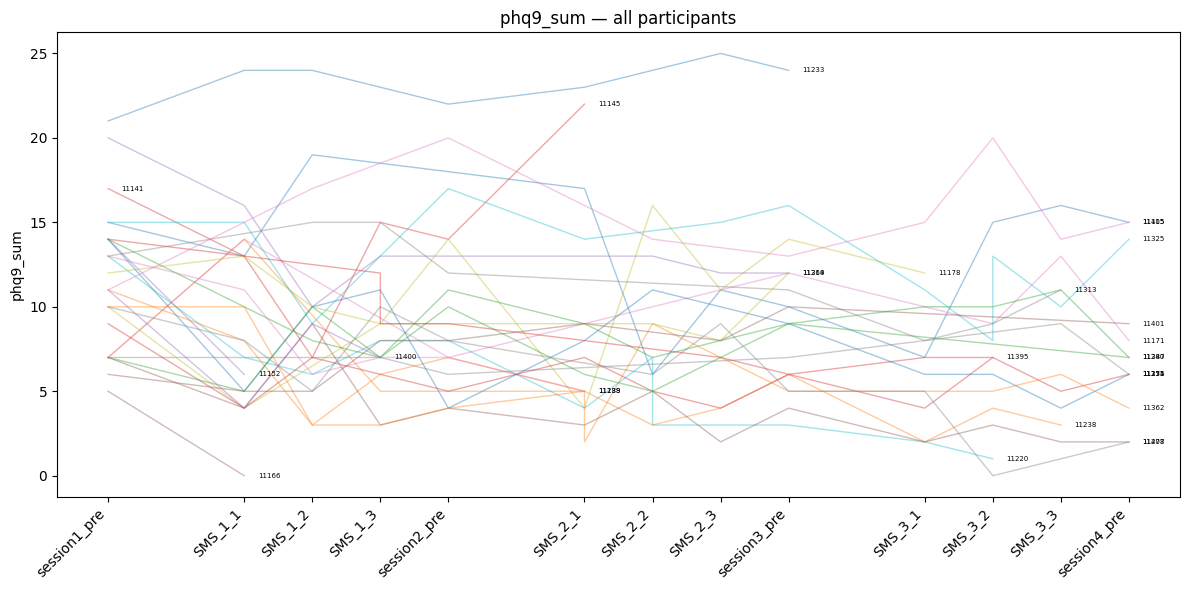

First MCID‐level worsening events (threshold ≥ 5):


,part_id,timepoint,phq9_sum,change
257,11139,SMS_1_1,14.0,7.0
317,11145,SMS_2_1,22.0,5.0
194,11171,SMS_1_1,14.0,7.0
295,11178,SMS_2_2,16.0,6.0
180,11405,SMS_1_2,17.0,6.0


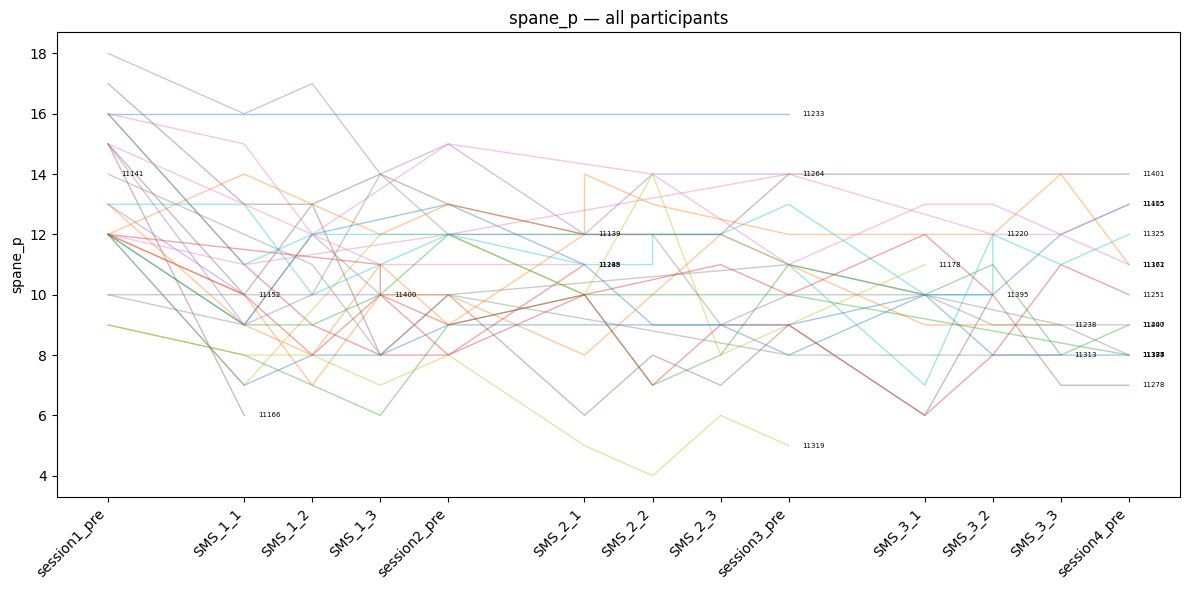

First MCID‐level worsening events (threshold ≥ 2):


,part_id,timepoint,spane_p,change
176,11115,SMS_1_1,9.0,-3.0
263,11145,SMS_1_1,11.0,-5.0
288,11152,SMS_1_1,10.0,-3.0
323,11166,SMS_1_1,6.0,-9.0
70,11174,session4_pre,8.0,-2.0
222,11178,SMS_1_1,7.0,-5.0
211,11220,SMS_1_1,11.0,-5.0
201,11238,SMS_1_1,10.0,-2.0
196,11240,SMS_1_2,7.0,-2.0
172,11251,SMS_1_1,10.0,-2.0


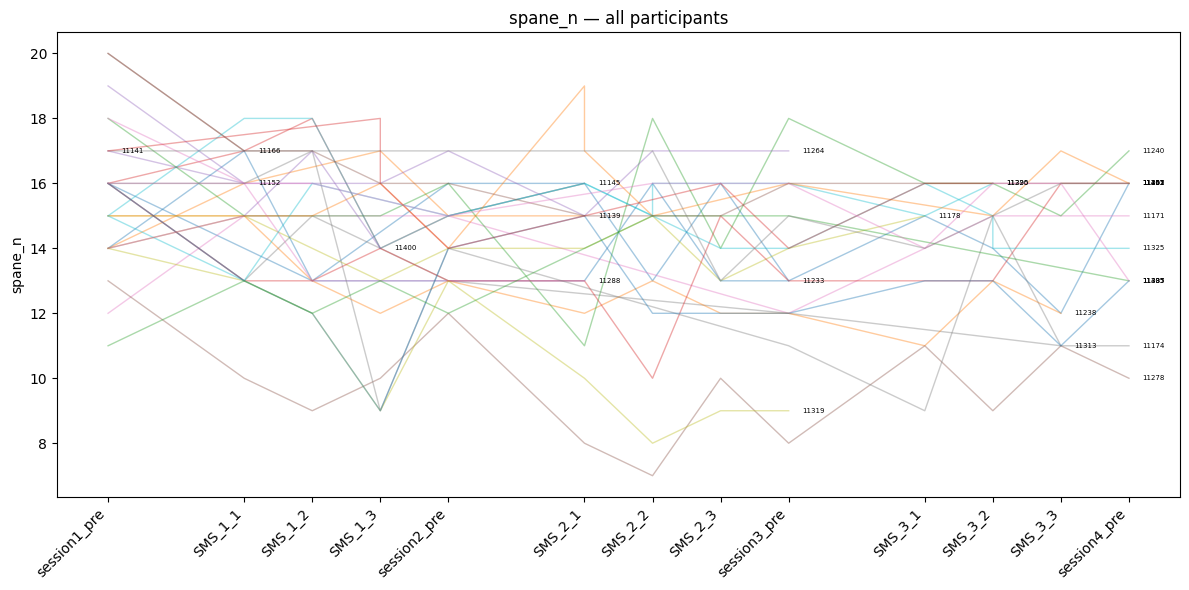

First MCID‐level worsening events (threshold ≥ 2):


,part_id,timepoint,spane_n,change
257,11139,SMS_1_1,16.0,2.0
283,11145,SMS_1_2,18.0,2.0
194,11171,SMS_1_1,15.0,3.0
211,11220,SMS_1_1,18.0,3.0
234,11233,SMS_1_1,17.0,3.0
203,11362,SMS_1_3,16.0,2.0
195,11387,SMS_1_1,13.0,2.0
312,11400,SMS_1_2,17.0,3.0


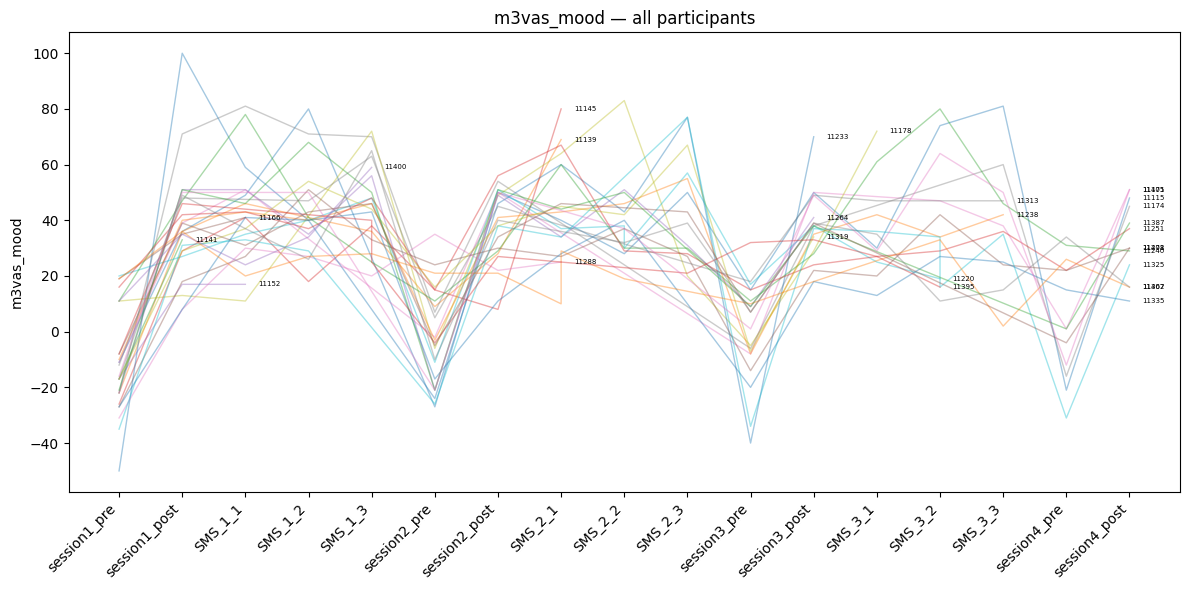

First MCID‐level worsening events (threshold ≥ 12):


,part_id,timepoint,m3vas_mood,change
32,11115,session2_pre,-27.0,-16.0
58,11178,session2_pre,-6.0,-17.0
49,11220,session2_pre,-11.0,-31.0
289,11362,SMS_3_3,2.0,-17.0


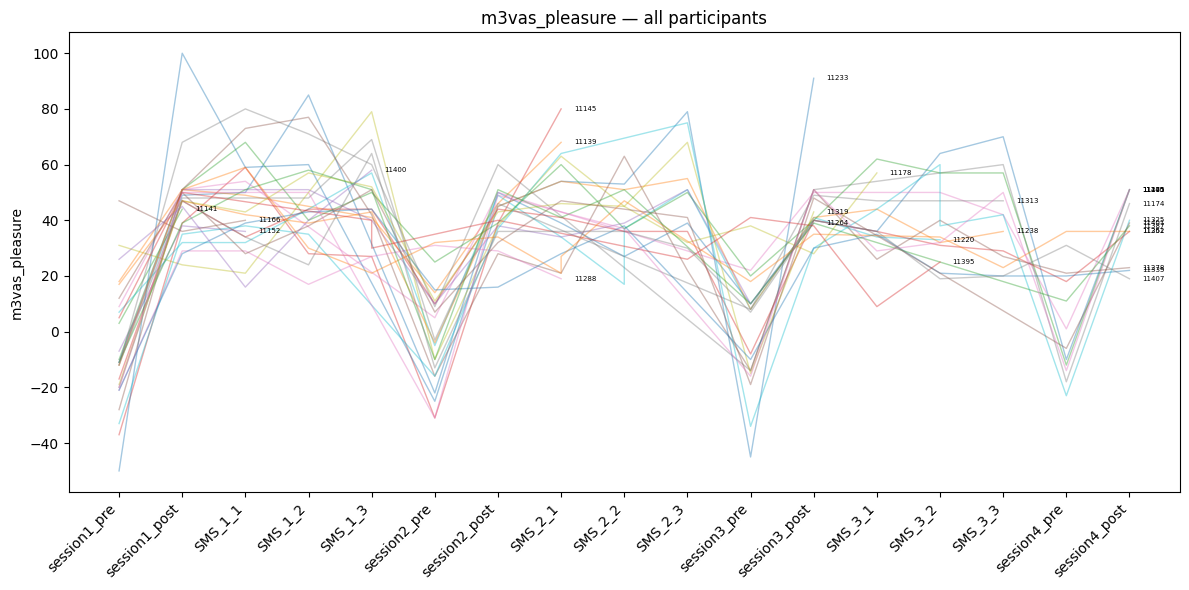

First MCID‐level worsening events (threshold ≥ 12):


,part_id,timepoint,m3vas_pleasure,change
58,11178,session2_pre,-10.0,-41.0
49,11220,session2_pre,-5.0,-12.0
43,11238,session2_pre,-4.0,-21.0
50,11401,session3_pre,-19.0,-31.0


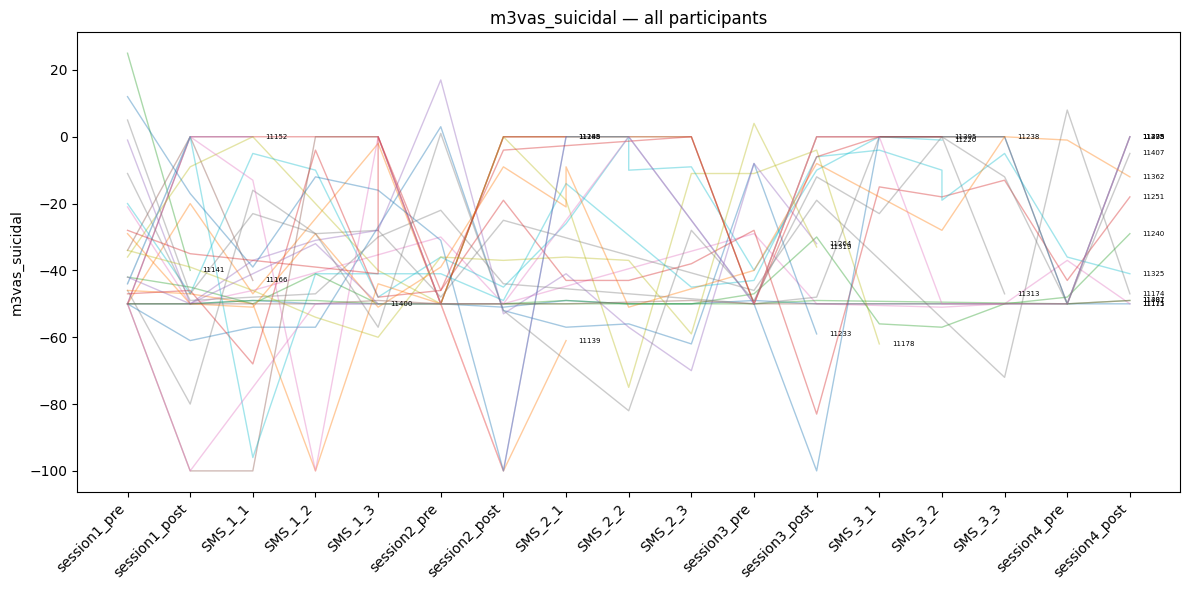

First MCID‐level worsening events (threshold ≥ 12):


,part_id,timepoint,m3vas_suicidal,change
131,11139,session1_post,-20.0,30.0
135,11145,session1_post,0.0,50.0
144,11152,session1_post,0.0,50.0
155,11166,session1_post,0.0,34.0
178,11174,SMS_1_1,-16.0,30.0
115,11178,session1_post,-9.0,27.0
211,11220,SMS_1_1,-5.0,15.0
60,11233,session2_pre,3.0,53.0
122,11238,session2_post,0.0,46.0
138,11240,session3_post,-30.0,12.0


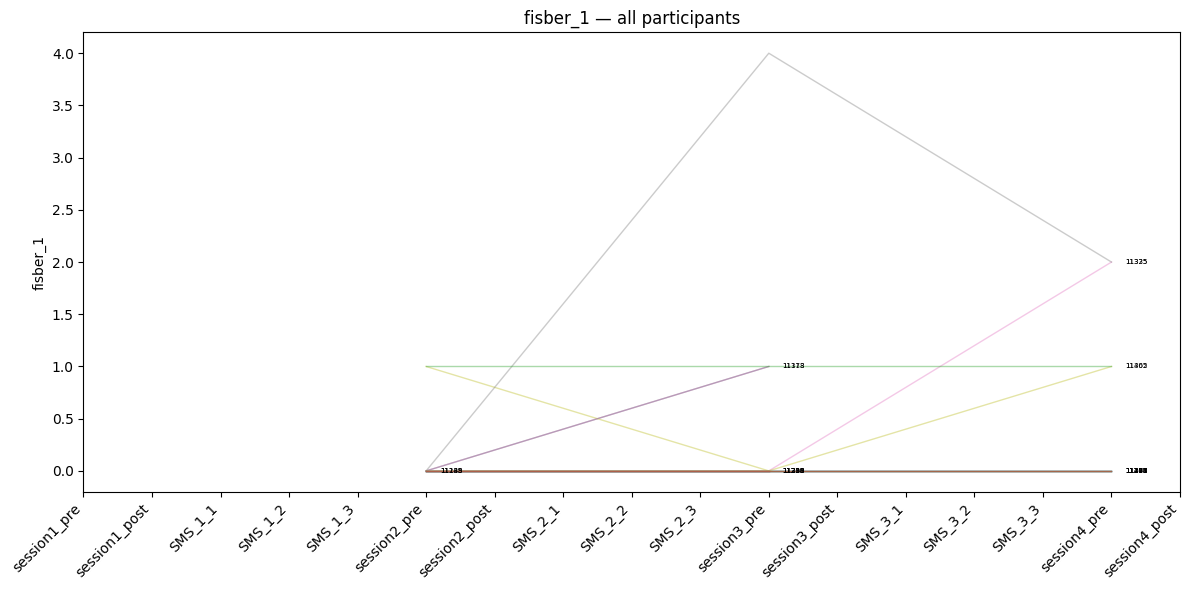

Worsened trajectories (blinded):


,part_id,timepoint,fisber_1
0,11178,session2_pre,0.0
1,11178,session3_pre,1.0
2,11313,session2_pre,0.0
3,11313,session3_pre,1.0
4,11325,session2_pre,0.0
5,11325,session3_pre,0.0
6,11325,session4_pre,2.0
7,11335,session2_pre,0.0
8,11335,session3_pre,4.0
9,11335,session4_pre,2.0


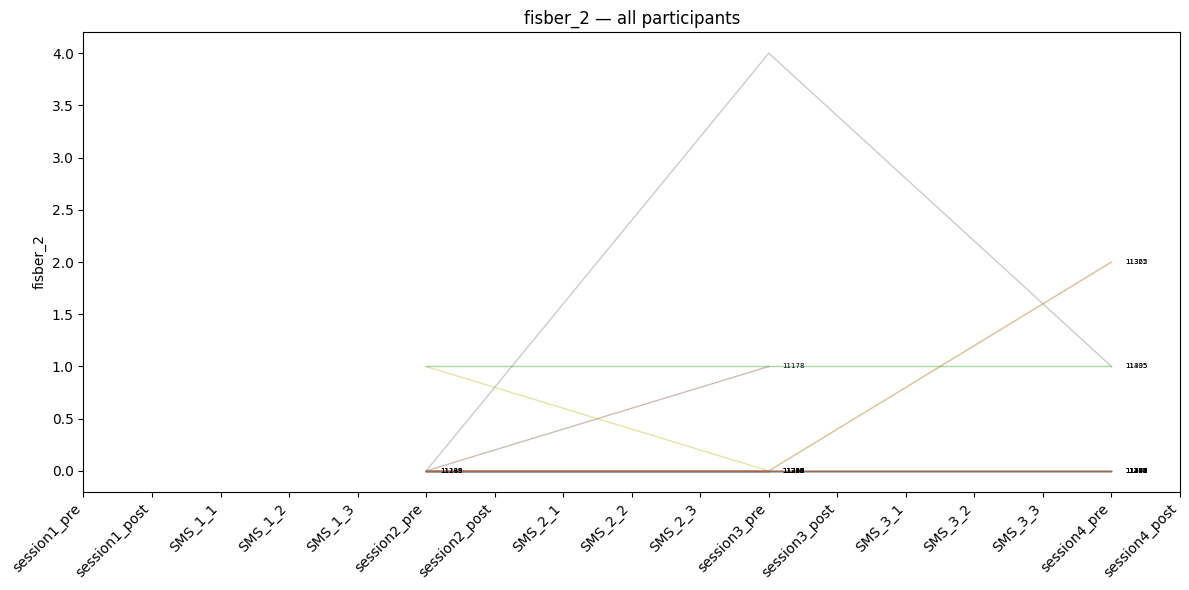

Worsened trajectories (blinded):


,part_id,timepoint,fisber_2
0,11178,session2_pre,0.0
1,11178,session3_pre,1.0
2,11325,session2_pre,0.0
3,11325,session3_pre,0.0
4,11325,session4_pre,2.0
5,11335,session2_pre,0.0
6,11335,session3_pre,4.0
7,11335,session4_pre,1.0
8,11362,session2_pre,0.0
9,11362,session3_pre,0.0


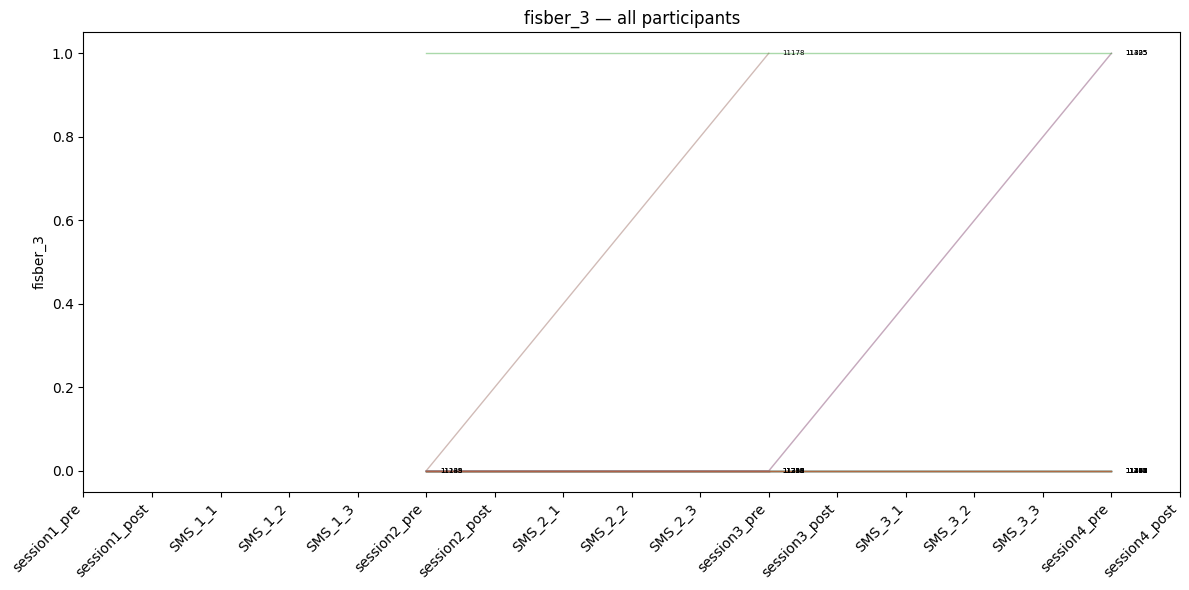

Worsened trajectories (blinded):


,part_id,timepoint,fisber_3
0,11178,session2_pre,0.0
1,11178,session3_pre,1.0
2,11325,session2_pre,0.0
3,11325,session3_pre,0.0
4,11325,session4_pre,1.0
5,11335,session2_pre,0.0
6,11335,session3_pre,0.0
7,11335,session4_pre,1.0


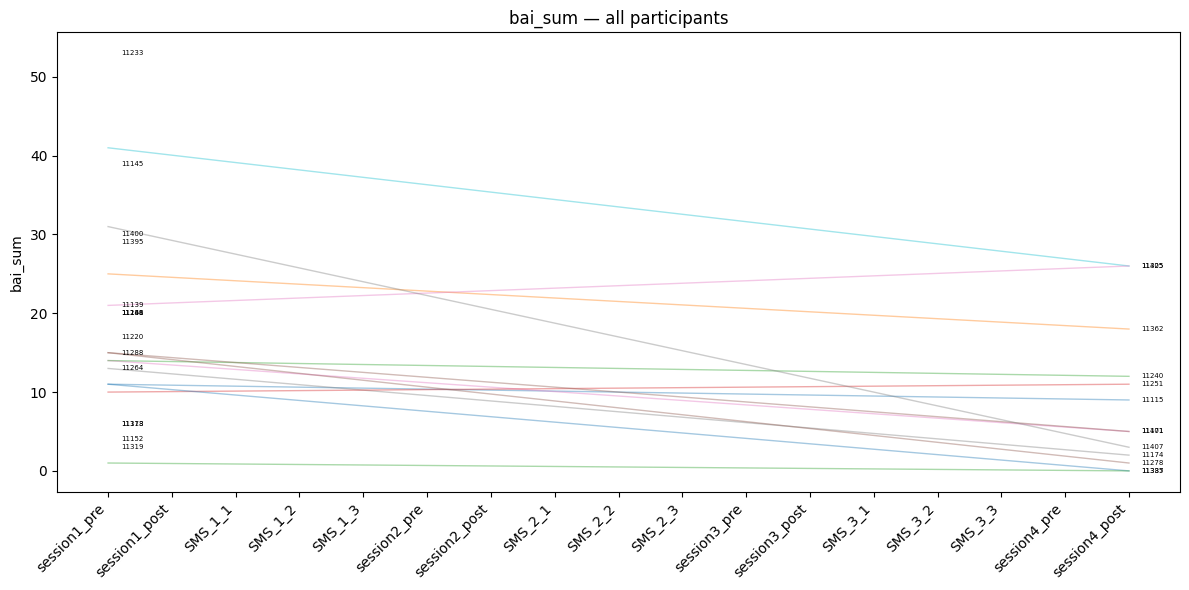

Worsened trajectories (blinded):


,part_id,timepoint,bai_sum
0,11251,session1_pre,10.0
1,11251,session4_post,11.0
2,11405,session1_pre,21.0
3,11405,session4_post,26.0


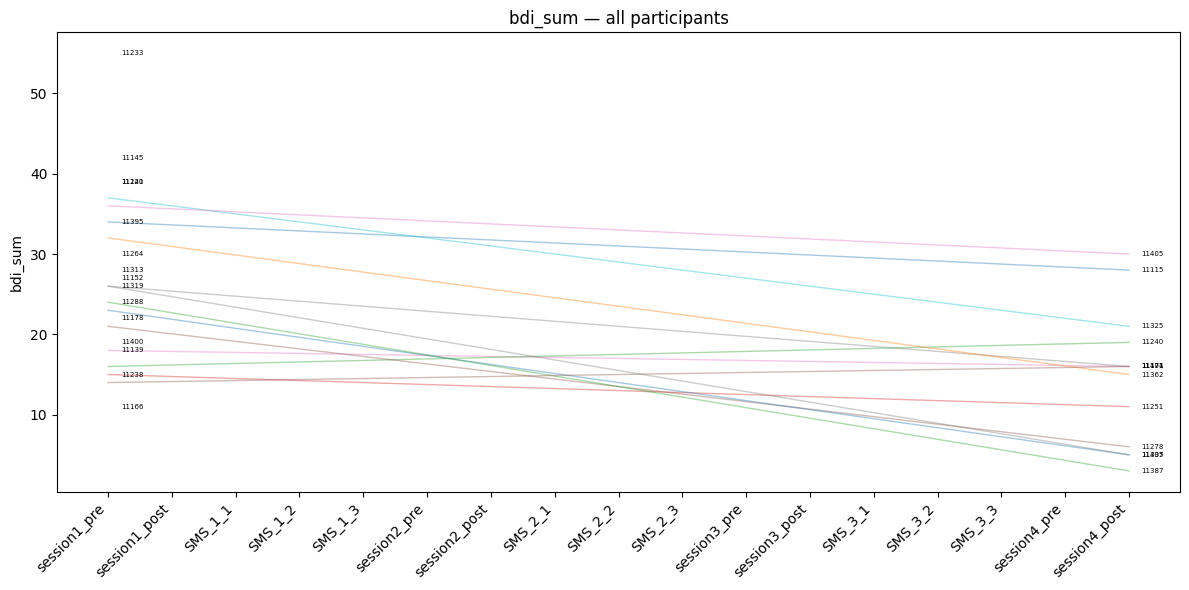

Worsened trajectories (blinded):


,part_id,timepoint,bdi_sum
0,11240,session1_pre,16.0
1,11240,session4_post,19.0
2,11401,session1_pre,14.0
3,11401,session4_post,16.0


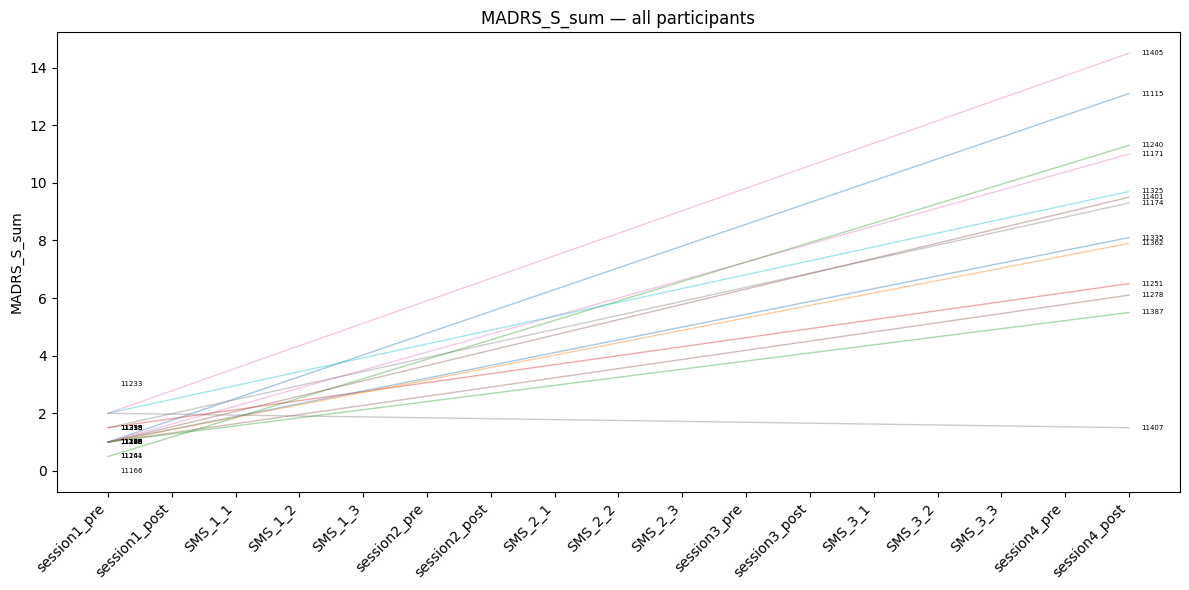

Worsened trajectories (blinded):


,part_id,timepoint,MADRS_S_sum
0,11115,session1_pre,1.0
1,11115,session4_post,13.1
2,11171,session1_pre,1.0
3,11171,session4_post,11.0
4,11174,session1_pre,1.5
5,11174,session4_post,9.3
6,11240,session1_pre,0.5
7,11240,session4_post,11.3
8,11251,session1_pre,1.5
9,11251,session4_post,6.5


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_trajectories_and_flag(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Copy & drop session*_post for PHQ-9 and SPANE scales
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, preserving order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp: i for i, tp in enumerate(ordered_timepoints)}

    # 3) Plot trajectories
    fig, ax = plt.subplots(figsize=(12,6))
    for pid, grp in df_plot.groupby('part_id'):
        s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
        if s.empty:
            continue
        x = s['timepoint'].cat.codes
        y = s[measure].astype(float)
        ax.plot(x, y, linewidth=1, alpha=0.4)
        ax.text(x.iloc[-1] + 0.2, y.iloc[-1], pid, fontsize=5, va='center')

    # 4) Set ticks only for the retained timepoints
    tick_locs   = [code_map[tp] for tp in timepoints_present]
    tick_labels = timepoints_present
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — all participants")
    plt.tight_layout()
    plt.show()

    # 5) Flag first MCID‐level worsening events
    if measure in mcid_thresholds:
        th = mcid_thresholds[measure]
        breach_events = []

        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = (
                grp_pid
                .dropna(subset=['timepoint', measure])
                .sort_values('timepoint')
                .loc[:, ['part_id','timepoint', measure]]
                .assign(change=lambda d: d[measure] - d[measure].iloc[0])
            )
            if measure in bad_if_higher:
                mask = seq['change'] >= th
            else:
                mask = seq['change'] <= -th

            if mask.any():
                breach_events.append(seq[mask].iloc[0])

        if breach_events:
            df_breaches = pd.DataFrame(breach_events)
            print(f"First MCID‐level worsening events (threshold ≥ {th}):")
            display(df_breaches)
        else:
            print(f"No participants worsened by at least the MCID of {th} for {measure}.")

    else:
        # 6) Fallback: any participant whose final point is worse than their first
        worsened = []
        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = grp_pid.dropna(subset=['timepoint', measure]) \
                         .sort_values('timepoint')[measure] \
                         .astype(float)
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower  and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            print("Worsened trajectories (blinded):")
            display(
                df_plot[df_plot['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
            )
        else:
            print("No worsening detected across the sample.")

#####
# RUN FOR ALL MEASURES
#####
for m in measures:
    plot_trajectories_and_flag(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)

Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                            \
timepoint    session1_post session2_post session3_post session4_post   
condition                                                              
control               0.00          0.30          0.00           0.0   
intervention          0.24          0.07          0.15           0.0   

                tol_sd_all                                            
timepoint    session1_post session2_post session3_post session4_post  
condition                                                             
control               0.00          0.67          0.00           0.0  
intervention          0.75          0.27          0.55           0.0

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero                             tol_sd_nonzero  \
timepoint       session1_post session2_post session3_post  session1_post   
condition                                                                  
control                   NaN           1.5           NaN            NaN   
intervention              2.0           1.0           2.0            1.0   

                                         n_side_effects                \
timepoint    session2_post session3_post  session1_post session2_post   
condition                                                               
control                0.5           NaN            NaN           2.0   
intervention           0.0           0.0            2.0           1.0   

                            
timepoint    session3_post  
condition                   
control                NaN  
intervention           1.0

Trimmed df_sms.part_id to first 5 characters
                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          242            Method:                    REML     
No. Groups:                28             Scale:                     6.7260   
Min. group size:           1              Log-Likelihood:            -632.7810
Max. group size:           13             Converged:                 Yes      
Mean group size:           8.6                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           10.160    1.281  7.934 0.000  7.651 12.670
condition[T.intervention]            0.587    1.648  0.356 0.722 -2.643  3.817
time_num                    

/tmp/ipython-input-9-343476141.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['condition','time_num'])['phq9_sum']
/tmp/ipython-input-9-343476141.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cond, grp in obs.groupby('condition'):


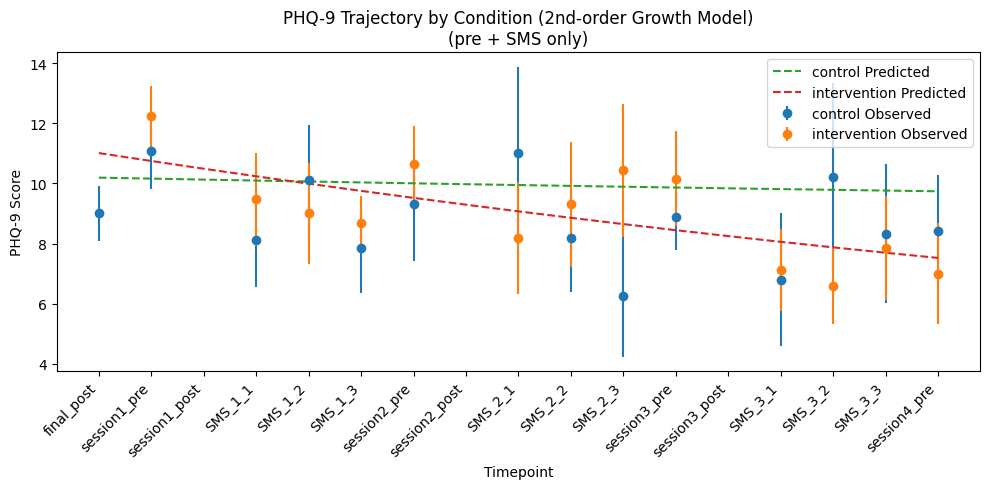

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smf

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITIES TO LOAD CSVs
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}'")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError):
        return None
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 2) CLEAN & SUM SCALES (BDI, BAI, MADRS)
#####
def sum_scale(df, cols, out):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[out] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # extract numeric from BDI
    for col in [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]:
        df[col] = df[col].astype(str).str.extract(r"^(\d+)")[0].astype(float)
    # BAI
    bai = get_scale_cols(df, 'bai', 21)
    if bai: sum_scale(df, bai, 'bai_sum')
    # BDI
    bdi = get_scale_cols(df, 'bdi', 21)
    if bdi: sum_scale(df, bdi, 'bdi_sum')
    # MADRS
    madrs = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs: sum_scale(df, madrs, 'MADRS_S_sum')

#####
# 3) STANDARDIZE M3VAS TO –50…+50
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        raw = next((c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)
        if var == 'suicidal':
            if raw is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[raw], errors='coerce') - 50
            elif ch is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[ch],  errors='coerce') - 50
        else:
            if raw is not None:
                df[f"m3vas_{var}"] = 50 - pd.to_numeric(df[raw], errors='coerce')
            elif ch is not None:
                df[f"m3vas_{var}"] = pd.to_numeric(df[ch], errors='coerce') - 50
    # drop old raw / change columns
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 4) CLEAN FISBER & COERCE TYPES
#####
for df in all_dfs:
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = df[c].astype(str).str.extract(r"(\d+)$")[0].astype(float)
    # numeric scales
    for col in [
        'phq9_sum','spane_p','spane_n',
        'm3vas_suicidal','m3vas_mood','m3vas_pleasure',
        'fisber_1','fisber_2','fisber_3',
        'bai_sum','bdi_sum','MADRS_S_sum'
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 5) ENSURE part_id & TAG TIMEPOINTS
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

if df_s1_pre is not None:
    df_s1_pre['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None:
    df_s2to4_pre['timepoint'] = df_s2to4_pre.apply(
        lambda r: f"session{r.session_n}_pre", axis=1
    )
if df_s2to4_post is not None:
    df_s2to4_post['timepoint'] = df_s2to4_post.apply(
        lambda r: f"session{r.session_n}_post", axis=1
    )
if df_s4_post is not None:
    df_s4_post['timepoint'] = 'session4_post'
if df_sms is not None:
    df_sms['timepoint'] = df_sms.apply(
        lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1
    )
if df_final is not None:
    df_final['timepoint'] = 'final_post'

# Concatenate
df_long = pd.concat(all_dfs, ignore_index=True)
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

# Merge condition assignments if available
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(df_assign[['part_id','condition']],
                            on='part_id', how='inner')

#####
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'], categories=ordered_timepoints, ordered=True
)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_long['time_num2'] = df_long['time_num']**2

# — after df_long['time_num2'] = df_long['time_num']**2 —

# 7a) EXCLUDE ALL sessionN_post TIMEPOINTS FOR THE PHQ-9 MODEL
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

#####
# 7b) FIT 2ND-ORDER MIXED-EFFECTS GROWTH MODEL FOR PHQ-9 (pre + SMS only)
#####
# — right after creating df_model —
# drop any rows missing the outcome or any of the predictors
df_model = df_model.dropna(
    subset=[
        'phq9_sum',    # outcome
        'time_num',
        'time_num2',   # quadratic term
        'condition'
    ]
)

# optionally ensure condition is treated as categorical
df_model['condition'] = df_model['condition'].astype('category')

# now fit
model = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res = model.fit(method='lbfgs')
print(res.summary())


#####
# 8) PLOT OBSERVED MEANS ± SEM AND MODEL PREDICTIONS (pre + SMS only)
#####
# Observed summary on df_model
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# Prediction grid stays the same
time_vals = np.arange(df_model['time_num'].min(),
                      df_model['time_num'].max()+1)
conds     = df_model['condition'].dropna().unique()
pred = pd.DataFrame([
    {'time_num': t, 'time_num2': t**2, 'condition': c}
    for c in conds for t in time_vals
])
pred['predicted'] = res.predict(pred)

# Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', label=f"{cond} Observed")
for cond in conds:
    sub = pred[pred['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '--',
             label=f"{cond} Predicted")

# Only label the timepoints actually in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition (2nd-order Growth Model)\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       242          Method:                  REML     
No. Groups:             28           Scale:                   7.4966   
Min. group size:        1            Log-Likelihood:          -629.4307
Max. group size:        13           Converged:               Yes      
Mean group size:        8.6                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     9.729    1.387  7.015 0.000  7.011 12.448
condition[T.intervention]    -0.590    1.777 -0.332 0.740 -4.073  2.894
tc                           -0.084    0.062 -1.346 0.178 -0.206  0.038
tc:condition[T.intervention] -0.172    0.082 -2.095 0.036 -0.333 -0.011
part_id V

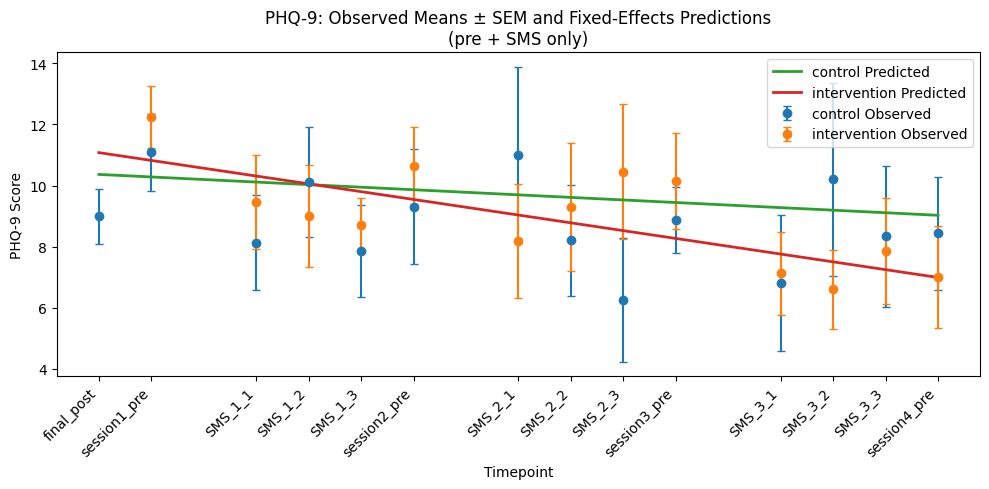

In [ ]:
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num'] = df_long['timepoint'].cat.codes

# center time
df_long['tc'] = df_long['time_num'] - df_long['time_num'].mean()

# 7) EXCLUDE sessionN_post FOR THE PHQ-9 LINEAR MODEL
# (so you only model pre + SMS assessments)
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

import statsmodels.formula.api as smf

# Random‐intercepts‐only linear growth with centered time
# — right before you call smf.mixedlm —

# 1) drop any remaining rows missing your outcome / predictors
df_model = df_model.dropna(
    subset=[
        'phq9_sum',  # outcome
        'tc',        # centered time
        'condition'  # grouping / interaction
    ]
)

# 2) reset to a fresh 0..N-1 index so that row_indices line up
df_model = df_model.reset_index(drop=True)

# now fit your random-intercepts model
model0 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res0 = model0.fit(method='lbfgs')
print(res0.summary())

import matplotlib.pyplot as plt

# 1) Observed means + SEM by condition & time_num (on df_model)
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 2) Fixed‐effects predictions from the random‐intercepts model
fe = res0.fe_params
mean_time = df_model['time_num'].mean()
preds = []
conds = df_model['condition'].dropna().unique()
time_vals = sorted(df_model['time_num'].unique())

for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc = t - mean_time
        pred = (
            fe['Intercept']
            + fe.get('condition[T.intervention]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})

pred_df = pd.DataFrame(preds)

# 3) Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

# xticks: only the timepoints in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9: Observed Means ± SEM and Fixed-Effects Predictions\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model_lin = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"   # random intercept only
)
res_lin = model_lin.fit(method='lbfgs', reml=False)
print(res_lin.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       242          Method:                  ML       
No. Groups:             28           Scale:                   7.4288   
Min. group size:        1            Log-Likelihood:          -627.7857
Max. group size:        13           Converged:               Yes      
Mean group size:        8.6                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     9.720    1.335  7.281 0.000  7.104 12.337
condition[T.intervention]    -0.577    1.711 -0.337 0.736 -3.929  2.776
tc                           -0.084    0.062 -1.358 0.175 -0.205  0.037
tc:condition[T.intervention] -0.171    0.082 -2.097 0.036 -0.331 -0.011
part_id V

Model Comparisons (Simple Linear Model 2 wins -- see BIC/AIC below for model degradation via adding quadratic term)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 1) Prepare time variables
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]

df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_long['time_num2'] = df_long['time_num']**2

# center time for models 2 & 3
df_long['tc'] = df_long['time_num'] - df_long['time_num'].mean()

# 2) Subset to “pre + SMS” only
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = (
    df_long[~mask_post]
    .dropna(subset=['phq9_sum','time_num','condition','tc'])  # remove any incomplete rows
    .reset_index(drop=True)
)
df_model['condition'] = df_model['condition'].astype('category')

# 3) Model 1: Quadratic growth with random intercepts & slopes (REML)
model1 = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res1 = model1.fit(method='lbfgs')  # default reml=True
print("\n=== Model 1: Quadratic + random slopes (REML) ===")
print(res1.summary())

# 4) Model 2: Linear growth with random intercept only (REML)
model2 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res2 = model2.fit(method='lbfgs')  # default reml=True
print("\n=== Model 2: Linear + random intercept (REML) ===")
print(res2.summary())

# 5) Model 3: Linear growth with random intercept only (ML)
model3 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res3 = model3.fit(method='lbfgs', reml=False)
print("\n=== Model 3: Linear + random intercept (ML) ===")
print(res3.summary())

# 6) Compare AICs (lower = better fit under ML/REML)
print(f"\nAICs:")
print(f"  Model 1 (quadratic, REML):   {res1.aic:.1f}")
print(f"  Model 2 (linear, REML):      {res2.aic:.1f}")
print(f"  Model 3 (linear, ML):        {res3.aic:.1f}")


=== Model 1: Quadratic + random slopes (REML) ===
                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          242            Method:                    REML     
No. Groups:                28             Scale:                     6.7260   
Min. group size:           1              Log-Likelihood:            -632.7810
Max. group size:           13             Converged:                 Yes      
Mean group size:           8.6                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           10.160    1.281  7.934 0.000  7.651 12.670
condition[T.intervention]            0.587    1.648  0.356 0.722 -2.643  3.817
time_num              

In [ ]:
# ML‐based quadratic model
res_quad_ml = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# ML‐based linear model
res_lin_ml = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs', reml=False)

# Now you can pull out AIC & BIC
print("Quadratic (ML) AIC:", res_quad_ml.aic, "BIC:", res_quad_ml.bic)
print("Linear    (ML) AIC:", res_lin_ml.aic,   "BIC:", res_lin_ml.bic)

Quadratic (ML) AIC: 1265.7828515250917 BIC: 1300.6722287866585
Linear    (ML) AIC: 1267.5713389677048 BIC: 1288.504965324645


In [ ]:
# --- Re-fit both models under ML (reml=False) and give them the names res_lin_ml / res_quad_ml ---

# linear model (ML):
res_lin_ml = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs', reml=False)

# quadratic model (ML):
res_quad_ml = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# now you can pull out log-likelihoods:
from scipy.stats import chi2

llf_lin  = res_lin_ml.llf
llf_quad = res_quad_ml.llf

# LRT statistic:
lr_stat = 2 * (llf_quad - llf_lin)

# df difference = # of extra fixed-effect parameters in quadratic:
df_diff = res_quad_ml.k_fe - res_lin_ml.k_fe

p_val = chi2.sf(lr_stat, df_diff)

print("Likelihood‐ratio test:")
print(f"  χ² = {lr_stat:.2f}")
print(f"  df = {df_diff}")
print(f"  p  = {p_val:.3f}")

# and for completeness, print AIC/BIC
print(f"\nAIC (linear):    {res_lin_ml.aic:.2f}")
print(f"AIC (quadratic): {res_quad_ml.aic:.2f}")
print(f"BIC (linear):    {res_lin_ml.bic:.2f}")
print(f"BIC (quadratic): {res_quad_ml.bic:.2f}")


Likelihood‐ratio test:
  χ² = 9.79
  df = 2
  p  = 0.007

AIC (linear):    1267.57
AIC (quadratic): 1265.78
BIC (linear):    1288.50
BIC (quadratic): 1300.67


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2

# 1) define your four models
model_specs = {
    'quad_REML': dict(
        formula    = "phq9_sum ~ time_num * condition + time_num2 * condition",
        re_formula = "~time_num",
        reml       = True
    ),
    'lin_REML': dict(
        formula    = "phq9_sum ~ tc * condition",
        re_formula = "~1",
        reml       = True
    ),
    'quad_ML': dict(
        formula    = "phq9_sum ~ time_num * condition + time_num2 * condition",
        re_formula = "~time_num",
        reml       = False
    ),
    'lin_ML': dict(
        formula    = "phq9_sum ~ tc * condition",
        re_formula = "~1",
        reml       = False
    ),
}

# 2) fit them all and store results
results = {}
for name, spec in model_specs.items():
    print(f"\n\n=== Fitting {name} (REML={spec['reml']}) ===")
    mod = smf.mixedlm(
        spec['formula'],
        data=df_model,
        groups="part_id",
        re_formula=spec['re_formula']
    )
    res = mod.fit(method='lbfgs', reml=spec['reml'])
    results[name] = res
    print(res.summary())

# 3) build a comparison table using the original spec to flag REML vs ML
cmp = pd.DataFrame({
    name: {
        'REML?':    spec['reml'],
        'LogLik':   results[name].llf,
        'AIC':      results[name].aic,
        'BIC':      results[name].bic,
        'n_params': len(results[name].params)
    }
    for name, spec in model_specs.items()
}).T

print("\n\n=== Model comparison ===")
print(cmp.sort_values(['REML?', 'AIC']))

# 4) ML‐based LRT: quad_ML vs lin_ML
llf_q = results['quad_ML'].llf
llf_l = results['lin_ML'].llf
lr_stat = 2 * (llf_q - llf_l)
df_diff = results['quad_ML'].k_fe - results['lin_ML'].k_fe
p_val   = chi2.sf(lr_stat, df_diff)

print(f"\nLRT (quad vs lin, ML): χ²({df_diff}) = {lr_stat:.2f}, p = {p_val:.3f}")



=== Fitting quad_REML (REML=True) ===
                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          242            Method:                    REML     
No. Groups:                28             Scale:                     6.7260   
Min. group size:           1              Log-Likelihood:            -632.7810
Max. group size:           13             Converged:                 Yes      
Mean group size:           8.6                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           10.160    1.281  7.934 0.000  7.651 12.670
condition[T.intervention]            0.587    1.648  0.356 0.722 -2.643  3.817
time_num                         

In [ ]:
# assume res_quad_ml is your ML‐fit of the quadratic model
from scipy import stats

# Wald test via statsmodels
hyp = "time_num:condition[T.intervention]=0, time_num2:condition[T.intervention]=0"
print(res_quad_ml.wald_test(hyp))

<Wald test (chi2): statistic=[[3.72188566]], p-value=0.15552592641918828, df_denom=2>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [ ]:
# “no interaction” nested model
mod_noint = smf.mixedlm(
    "phq9_sum ~ time_num + time_num2 + condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# likelihood‐ratio test
llf_full  = res_quad_ml.llf
llf_noint = mod_noint.llf
lr_stat   = 2*(llf_full - llf_noint)
df_diff   = res_quad_ml.k_fe - mod_noint.k_fe
p_val     = stats.chi2.sf(lr_stat, df_diff)
print(f"Joint LRT for all cond×poly terms: χ²({df_diff})={lr_stat:.2f}, p={p_val:.3f}")

Joint LRT for all cond×poly terms: χ²(2)=3.77, p=0.152


In [ ]:
import numpy as np

# pick a time—for example, t = max(time_num)
t0 = df_model['time_num'].max()

# linear coefficient
b1 = res_quad_ml.params['time_num:condition[T.intervention]']
# quad coefficient
b2 = res_quad_ml.params['time_num2:condition[T.intervention]']

# derivative difference
d = b1 + 2*t0*b2
print(f"Slope diff at t={t0}: {d:.3f}")
# …then get its SE via res_quad_ml.cov_params() and compute a z‐test…

Slope diff at t=15: -0.145


In [ ]:
# ML‐fit partial polynomial model
res_partial = smf.mixedlm(
    "phq9_sum ~ time_num*condition + time_num2",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

print(res_partial.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        phq9_sum 
No. Observations:         242            Method:                    ML       
No. Groups:               28             Scale:                     6.6954   
Min. group size:          1              Log-Likelihood:            -622.9619
Max. group size:          13             Converged:                 Yes      
Mean group size:          8.6                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          10.112    1.227  8.240 0.000  7.707 12.518
condition[T.intervention]           0.655    1.576  0.415 0.678 -2.435  3.744
time_num                           -0.032    0.092 -0.350 0.726 -0.212  0.147
time_n

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2

# ─── Fit three ML models ────────────────────────────────────────────────────
# 1) Linear only
mod_lin = smf.mixedlm(
    "phq9_sum ~ time_num * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res_lin = mod_lin.fit(method='lbfgs', reml=False)

# 2) Partial quadratic (common curvature, slope×cond only)
mod_part = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res_part = mod_part.fit(method='lbfgs', reml=False)

# 3) Full quadratic (both linear & quadratic × condition)
mod_full = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res_full = mod_full.fit(method='lbfgs', reml=False)

# ─── Summaries ───────────────────────────────────────────────────────────────
print("\n=== Linear ML ==="); print(res_lin.summary())
print("\n=== Partial-quadratic ML ==="); print(res_part.summary())
print("\n=== Full-quadratic ML ==="); print(res_full.summary())

# ─── Comparison table ────────────────────────────────────────────────────────
cmp = pd.DataFrame({
    'linear':       {'llf': res_lin.llf,  'AIC': res_lin.aic,  'BIC': res_lin.bic},
    'partial_quad': {'llf': res_part.llf, 'AIC': res_part.aic, 'BIC': res_part.bic},
    'full_quad':    {'llf': res_full.llf, 'AIC': res_full.aic, 'BIC': res_full.bic},
}).T
print("\n=== model comparison ===")
print(cmp)

# ─── LRT for slope×condition within the partial-quadratic model ─────────────
#    (i.e. compare partial-quad vs same model without time:cond term)
mod_noint = smf.mixedlm(
    "phq9_sum ~ time_num + time_num2 + condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

lr = 2*(res_part.llf - mod_noint.llf)
df_diff = res_part.k_fe - mod_noint.k_fe
pval = chi2.sf(lr, df_diff)

print(f"\nSlope×condition LRT (partial): χ²({df_diff}) = {lr:.2f}, p = {pval:.3f}")


=== Linear ML ===
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        phq9_sum 
No. Observations:         242            Method:                    ML       
No. Groups:               28             Scale:                     7.4288   
Min. group size:          1              Log-Likelihood:            -627.7857
Max. group size:          13             Converged:                 Yes      
Mean group size:          8.6                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          10.284    1.377  7.468 0.000  7.585 12.983
condition[T.intervention]           0.572    1.771  0.323 0.747 -2.900  4.044
time_num                           -0.084    0.062 -1.358 0.175 -

In [ ]:
# from your partial-quadratic fit `res_part`
coef = res_part.params['time_num:condition[T.intervention]']
se   = res_part.bse['time_num:condition[T.intervention]']
ci_lower, ci_upper = coef - 1.96*se, coef + 1.96*se
print(f"Slope diff = {coef:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")

Slope diff = -0.228, 95% CI = [-0.462, 0.007]


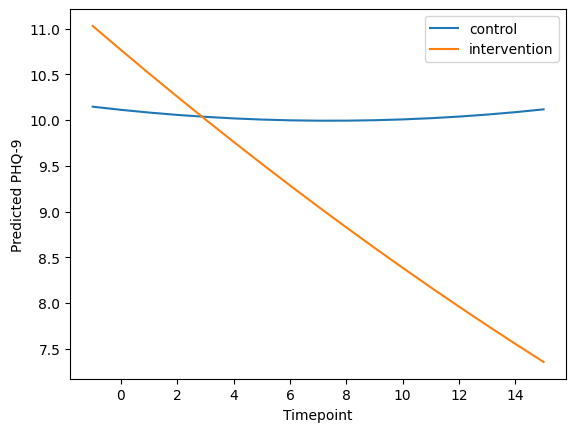

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build prediction DataFrame
grid = np.arange(df_model['time_num'].min(), df_model['time_num'].max()+1)
pred = pd.DataFrame({
    'time_num':    np.tile(grid, 2),
    'time_num2':   np.tile(grid**2, 2),
    'condition':   ['control']*len(grid) + ['intervention']*len(grid),
    'part_id':     df_model['part_id'].iloc[0],  # dummy
})
pred['phq9'] = res_part.predict(pred)

# 2) Plot
plt.figure()
for grp, sub in pred.groupby('condition'):
    plt.plot(sub['time_num'], sub['phq9'], label=grp)
plt.xlabel('Timepoint')
plt.ylabel('Predicted PHQ-9')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import trange

def fit_slope_diff(df):
    # fit the partial-quadratic ML model
    res = smf.mixedlm(
        "phq9_sum ~ time_num * condition + time_num2",
        data=df,
        groups="part_id",
        re_formula="~time_num"
    ).fit(method='lbfgs', reml=False)
    return res.params['time_num:condition[T.intervention]']

n_boot = 2000
boot_est = np.zeros(n_boot)
part_ids = df_model['part_id'].unique()

for i in trange(n_boot):
    # resample participants with replacement
    samp_ids = np.random.choice(part_ids, size=len(part_ids), replace=True)
    df_boot = pd.concat([df_model[df_model.part_id==pid] for pid in samp_ids], ignore_index=True)
    boot_est[i] = fit_slope_diff(df_boot)

# bootstrap percentile 95% CI
ci_lower, ci_upper = np.percentile(boot_est, [2.5, 97.5])
print(f"Bootstrap slope×cond diff 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# density or histogram
import matplotlib.pyplot as plt
plt.hist(boot_est, bins=30, density=True)
plt.axvline(ci_lower, color='k', linestyle='--')
plt.axvline(ci_upper, color='k', linestyle='--')
plt.xlabel("Slope Diff"); plt.title("Bootstrap Distribution")
plt.show()

NameError: name 'boot_est' is not defined

In [ ]:
# install Bayesian stuff

# the “%” magic ensures it installs into the current kernel
%pip install pymc3 arviz

# install the missing Debian packages
!apt-get update -qq
!apt-get install -y -qq python3-distutils libopenblas-dev liblapack-dev
# then install PyMC3/Aesara via pip
%pip install pymc3 arviz

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# --- prepare your data arrays ---
y        = df_model['phq9_sum'].values
time     = df_model['time_num'].values
time2    = df_model['time_num2'].values
cond     = (df_model['condition']=='intervention').astype(int).values
pid, pid_idx = np.unique(df_model['part_id'], return_inverse=True)
n_pat    = len(pid)

with pm.Model() as partial_quad:

    # Hyperpriors for random effects (independent)
    σ_a = pm.HalfNormal('σ_a', sigma=5)         # intercept SD
    σ_b = pm.HalfNormal('σ_b', sigma=1)         # slope SD

    # Subject-level effects
    a = pm.Normal('a', mu=0, sigma=σ_a, shape=n_pat)    # random intercept
    b = pm.Normal('b', mu=0, sigma=σ_b, shape=n_pat)    # random linear slope

    # Fixed effects
    intercept  = pm.Normal('Intercept',     mu=10, sigma=5)
    b_time     = pm.Normal('b_time',        mu=-0.1, sigma=0.1)
    b_time2    = pm.Normal('b_time2',       mu= 0.0, sigma=0.05)
    b_cond     = pm.Normal('b_cond',        mu= 0.0, sigma=5)
    b_time_c   = pm.Normal('b_time:cond',   mu= 0.0, sigma=0.1)
    # no quadratic×cond in partial-quadratic:
    b_time2_c  = pm.ConstantData('b_time2:cond', 0.0)

    # Linear predictor
    μ = (
        intercept
        + a[pid_idx]
        + (b_time + b[pid_idx])*time
        + b_time2*time2
        + b_cond*cond
        + b_time_c*time*cond
        + b_time2_c*time2*cond
    )

    # Residual SD
    σ_y = pm.HalfNormal('σ_y', sigma=5)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=μ, sigma=σ_y, observed=y)

    # Sample
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

# --- Summarize slope×condition posterior ---
az.plot_posterior(trace, var_names=['b_time:cond'], hdi_prob=0.95)
print(az.summary(trace, var_names=['b_time:cond']))
print("P(b_time:cond < 0) =",
      np.mean(trace.posterior['b_time:cond'].values < 0))

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np

post = trace.posterior['b_time:cond'].values.flatten()
# P(effect < –0.05)
print("P(b_time:cond < –0.05) =", np.mean(post < -0.05))
# P(effect within ±0.05)
print("P(|b_time:cond| < 0.05) =", np.mean(np.abs(post) < 0.05))

kde = gaussian_kde(post)
posterior_density_at_zero = kde(0)[0]
# prior for b_time:cond was Normal(0,0.1), so its density at zero is:
prior_density_at_zero = 1/(0.1 * np.sqrt(2*np.pi))
BF10 = prior_density_at_zero / posterior_density_at_zero
print("BF₁₀ (neg effect vs. null) ≈", BF10)

P(b_time:cond < –0.05) = 0.70775
P(|b_time:cond| < 0.05) = 0.25325
BF₁₀ (neg effect vs. null) ≈ 1.6377214928282977


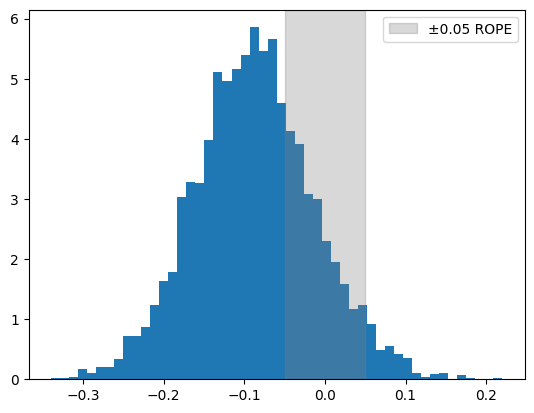

In [ ]:
import matplotlib.pyplot as plt
post = trace.posterior['b_time:cond'].values.flatten()
plt.hist(post, bins=50, density=True)
plt.axvspan(-0.05, 0.05, color='gray', alpha=0.3, label='±0.05 ROPE')
plt.legend(); plt.show()

Future P(< 0)           = 0.9796
Future P(< –0.05)       = 0.816
Future P(|effect|<0.05) = 0.1832


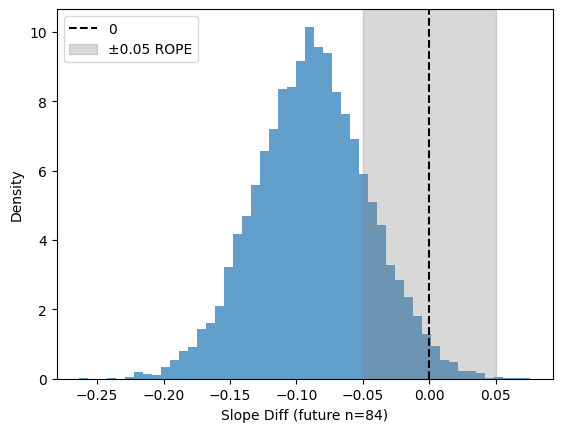

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) extract your posterior on b_time:cond
post = trace.posterior['b_time:cond'].values.flatten()
mu_current   = post.mean()
sd_current   = post.std(ddof=1)
n_current    = len(np.unique(df_model['part_id']))
n_future     = 84

# 2) compute the future (approximate) sampling SD
sd_future = sd_current * np.sqrt(n_current / n_future)

# 3) simulate 10k “future” estimates
sim = np.random.normal(loc=mu_current, scale=sd_future, size=10_000)

# 4) compute the quantities you care about
print("Future P(< 0)           =", np.mean(sim < 0))
print("Future P(< –0.05)       =", np.mean(sim < -0.05))
print("Future P(|effect|<0.05) =", np.mean(np.abs(sim) < 0.05))

# 5) visualize
plt.hist(sim, bins=50, density=True, alpha=0.7)
plt.axvline(0, color='k', linestyle='--', label="0")
plt.axvspan(-0.05, +0.05, color='gray', alpha=0.3, label="±0.05 ROPE")
plt.legend()
plt.xlabel("Slope Diff (future n=84)")
plt.ylabel("Density")
plt.show()

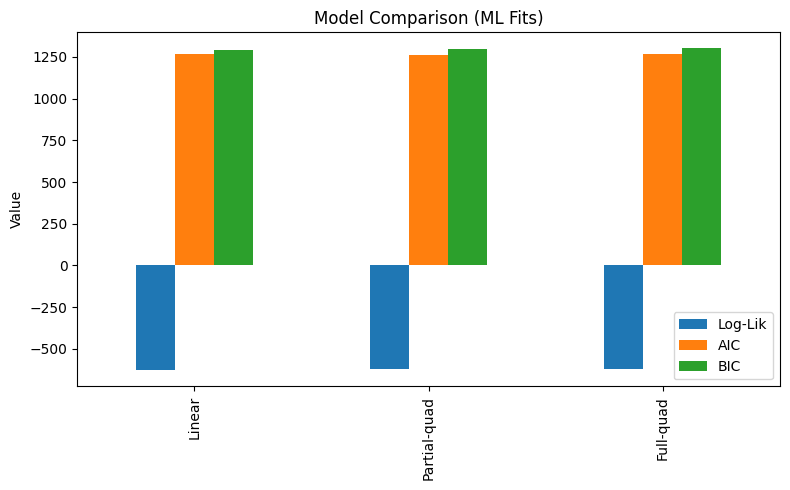

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Collect the metrics
model_names = ['Linear', 'Partial-quad', 'Full-quad']
llf  = [res_lin.llf,  res_part.llf,  res_full.llf]
aic  = [res_lin.aic,  res_part.aic,  res_full.aic]
bic  = [res_lin.bic,  res_part.bic,  res_full.bic]

df_metrics = pd.DataFrame({
    'Log-Lik': llf,
    'AIC':     aic,
    'BIC':     bic
}, index=model_names)

# 2. Plot grouped bar chart
ax = df_metrics.plot(kind='bar', figsize=(8,5))
ax.set_ylabel('Value')
ax.set_title('Model Comparison (ML Fits)')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

/tmp/ipython-input-45-2855758623.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cond, df_sub in df_model.groupby('condition'):


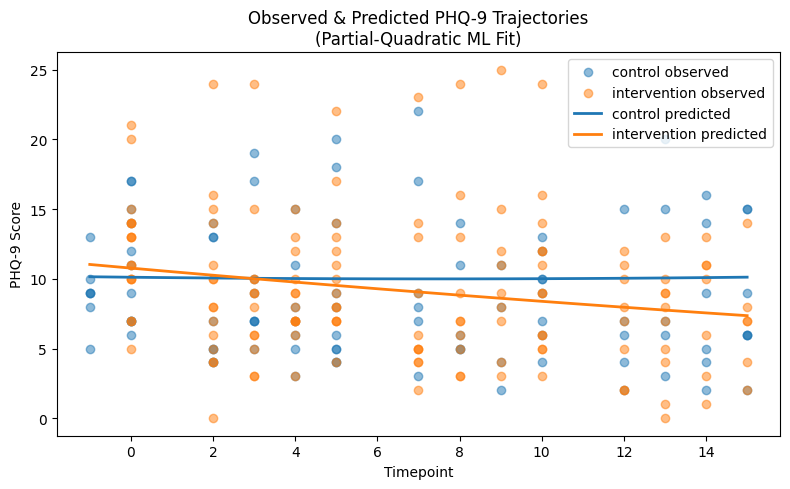

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Build a prediction grid
time_grid = np.arange(df_model['time_num'].min(),
                      df_model['time_num'].max()+1)

pred_df = pd.DataFrame({
    'time_num':  np.tile(time_grid, 2),
    'time_num2': np.tile(time_grid**2, 2),
    'condition': ['control']*len(time_grid) + ['intervention']*len(time_grid),
    # part_id just needs to be present; we use the first ID as a placeholder
    'part_id':   df_model['part_id'].iloc[0]
})

# 2. Generate predictions
pred_df['phq9_pred'] = res_part.predict(pred_df)

# 3. Plot
fig, ax = plt.subplots(figsize=(8,5))
colors = {'control':'tab:blue', 'intervention':'tab:orange'}

# scatter raw observations
for cond, df_sub in df_model.groupby('condition'):
    ax.scatter(df_sub['time_num'], df_sub['phq9_sum'],
               color=colors[cond], alpha=0.5, label=f'{cond} observed')

# plot fitted curves
for cond in ['control','intervention']:
    df_sub = pred_df[pred_df['condition']==cond]
    ax.plot(df_sub['time_num'], df_sub['phq9_pred'],
            color=colors[cond], lw=2, label=f'{cond} predicted')

ax.set_xlabel('Timepoint')
ax.set_ylabel('PHQ-9 Score')
ax.set_title('Observed & Predicted PHQ-9 Trajectories\n(Partial-Quadratic ML Fit)')
ax.legend()
plt.tight_layout()
plt.show()

FINAL MODEL TWO (Linear REML)

In [ ]:
import statsmodels.formula.api as smf

# (Re)fit the final linear REML model
final_model = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs')  # default reml=True

print(final_model.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       242          Method:                  REML     
No. Groups:             28           Scale:                   7.4966   
Min. group size:        1            Log-Likelihood:          -629.4307
Max. group size:        13           Converged:               Yes      
Mean group size:        8.6                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     9.729    1.387  7.015 0.000  7.011 12.448
condition[T.intervention]    -0.590    1.777 -0.332 0.740 -4.073  2.894
tc                           -0.084    0.062 -1.346 0.178 -0.206  0.038
tc:condition[T.intervention] -0.172    0.082 -2.095 0.036 -0.333 -0.011
part_id V

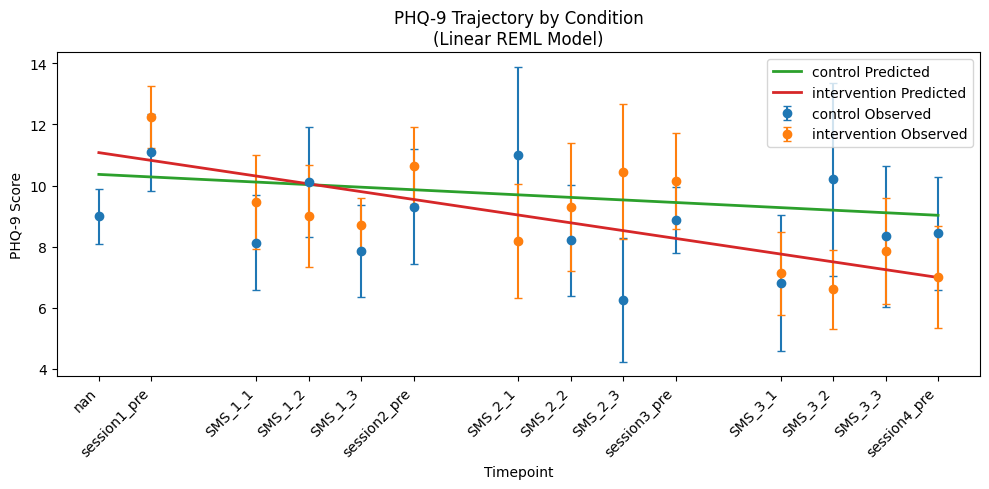

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Observed means ± SEM, silencing the warning
obs = (
    df_model
    .groupby(['condition','time_num'], observed=True)['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 2) Build fixed-effects predictions
fe        = final_model.fe_params
time_vals = sorted(df_model['time_num'].unique())
mean_t    = df_model['time_num'].mean()
conds     = df_model['condition'].cat.categories

preds = []
for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc   = t - mean_t
        pred = (
            fe['Intercept']
            + fe.get(f'condition[T.{cond}]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})

pred_df = pd.DataFrame(preds)

# 3) Dynamically map time_num → label
label_map = (
    df_model[['time_num','timepoint']]
    .drop_duplicates()
    .set_index('time_num')['timepoint']
    .to_dict()
)
labels = [label_map[t] for t in time_vals]

# 4) Plot observed ± SEM and model fits
plt.figure(figsize=(10,5))

# Observed
for cond, grp in obs.groupby('condition', observed=True):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )

# Predicted
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

plt.xticks(time_vals, labels, rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition\n(Linear REML Model)")
plt.legend()
plt.tight_layout()
plt.show()

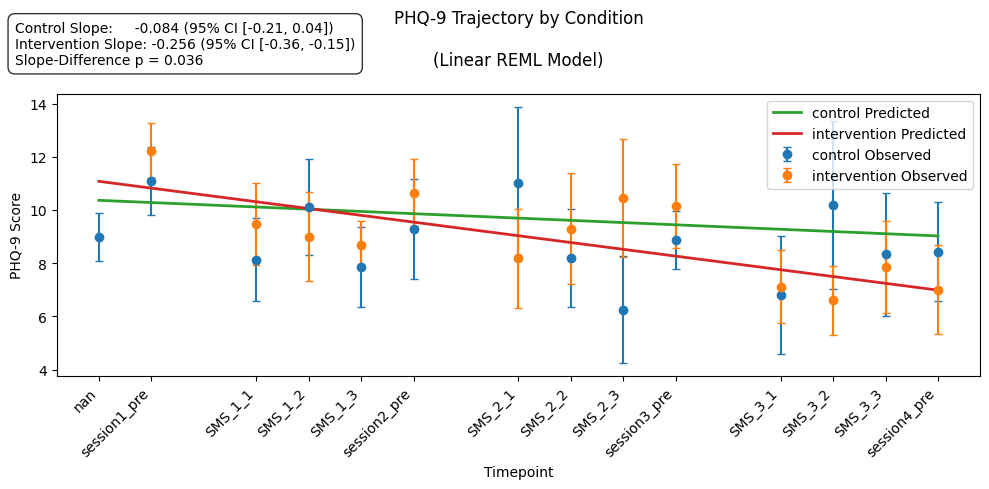

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── 1) EXTRACT FIXED‐EFFECTS & COVARIANCE ─────────────────────────────
params = final_model.fe_params
vcov   = final_model.cov_params()

# control slope & SE
s_ctrl = params['tc']
se_ctrl = np.sqrt(vcov.loc['tc','tc'])

# intervention slope & SE (s_ctrl + delta)
delta = params['tc:condition[T.intervention]']
var_delta = vcov.loc['tc:condition[T.intervention]','tc:condition[T.intervention]']
covar = vcov.loc['tc','tc:condition[T.intervention]']
se_int = np.sqrt(se_ctrl**2 + var_delta + 2*covar)
s_int = s_ctrl + delta

# 95% CIs
z = norm.ppf(0.975)
ci_ctrl = (s_ctrl - z*se_ctrl, s_ctrl + z*se_ctrl)
ci_int  = (s_int  - z*se_int,  s_int  + z*se_int)

# p‐value for slope difference = p of the interaction
p_diff = final_model.pvalues['tc:condition[T.intervention]']

# ─── 2) COMPUTE PREDICTED OBS + FIT ────────────────────────────────────
# (this is your plotting data from before)
# obs  = ...   # dataframe with ['condition','time_num','mean','sem']
# pred_df = ... # dataframe with ['condition','time_num','predicted']
time_vals = sorted(df_model['time_num'].unique())

# ─── 3) COMPUTE TIMEPOINT‐WISE SIGNIFICANCE OF GAP ────────────────────
# for each t, gap = pred_int - pred_ctrl; its se via delta‐method
# pre‐compute var(beta_cond), var(delta), cov(beta_cond,delta)
vc_b  = vcov.loc['condition[T.intervention]','condition[T.intervention]']
cov_b_d = vcov.loc['condition[T.intervention]','tc:condition[T.intervention]']

gaps, ses, sig = [], [], []
for t in time_vals:
    tc = t - df_model['time_num'].mean()
    # gap = condition main effect + tc×condition effect
    gap = params['condition[T.intervention]'] + delta * tc
    var_gap = vc_b + (tc**2)*var_delta + 2*tc*cov_b_d
    se_gap = np.sqrt(var_gap)
    gaps.append(gap); ses.append(se_gap)
    sig.append(abs(gap) > z*se_gap)

# ─── 4) PLOTTING ───────────────────────────────────────────────────────
plt.figure(figsize=(10,5))

# observed
for cond, grp in obs.groupby('condition', observed=True):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', capsize=3, label=f"{cond} Observed")

# predicted
for cond in pred_df['condition'].unique():
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '-', lw=2,
             label=f"{cond} Predicted")

# annotate significant gaps
ymax = max(pred_df['predicted']) + 0.5
for t, is_sig in zip(time_vals, sig):
    if is_sig:
        plt.text(t, ymax, '*', ha='center', va='bottom', fontsize=14)

# add slope‐text box
txt = (
    f"Control Slope:     {s_ctrl:.3f} "
    f"(95% CI [{ci_ctrl[0]:.2f}, {ci_ctrl[1]:.2f}])\n"
    f"Intervention Slope: {s_int:.3f} "
    f"(95% CI [{ci_int[0]:.2f}, {ci_int[1]:.2f}])\n"
    f"Slope‐Difference p = {p_diff:.3f}"
)
plt.gcf().text(0.02, 0.86, txt, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

# finalize axes
label_map = (
    df_model[['time_num','timepoint']]
    .drop_duplicates()
    .set_index('time_num')['timepoint']
    .to_dict()
)
plt.xticks(time_vals, [label_map[t] for t in time_vals],
           rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition\n\n(Linear REML Model)\n")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Loaded 'pre_session_1' from wp2_pre_session_1_July 13, 2025_17.41.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 13, 2025_17.41.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 13, 2025_17.42.csv
Loaded 'post_session_4' from wp2_post_session_4_July 13, 2025_17.42.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 13, 2025_17.43.csv
Trimmed df_sms.part_id to first 5 characters
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


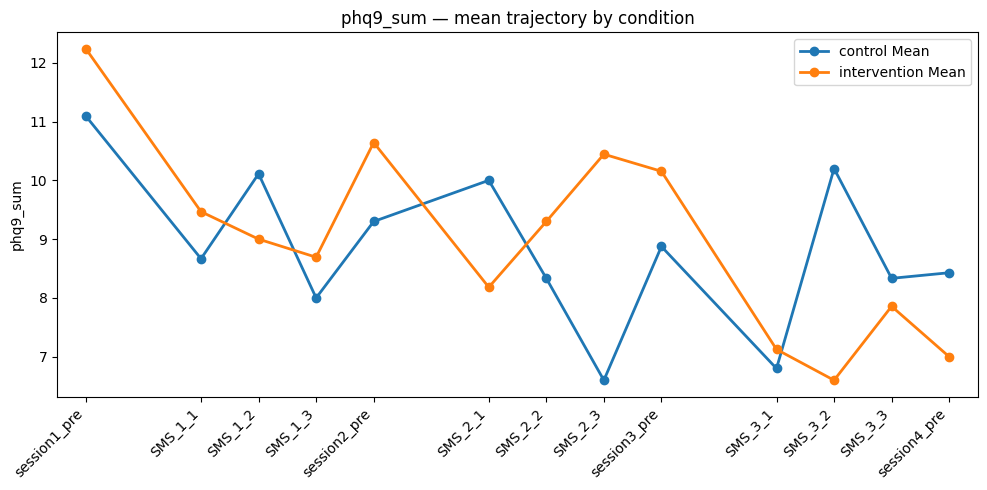

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


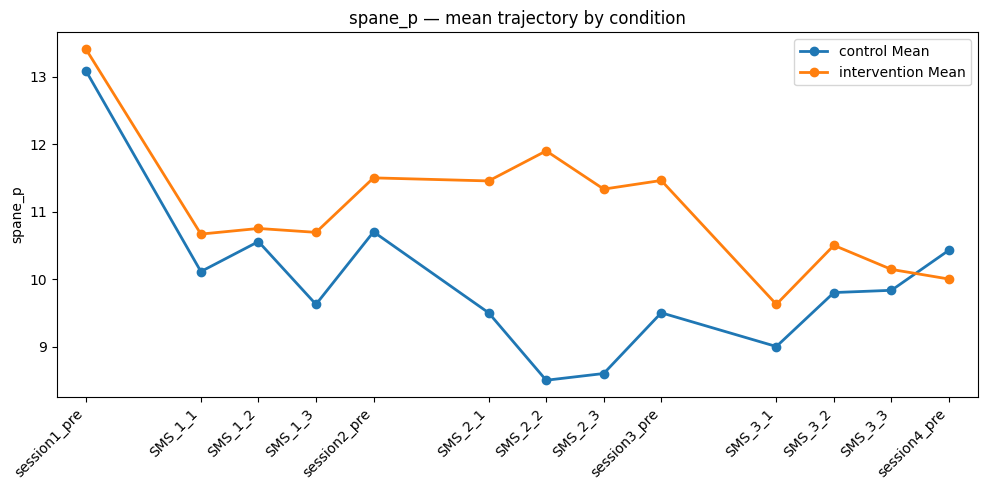

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


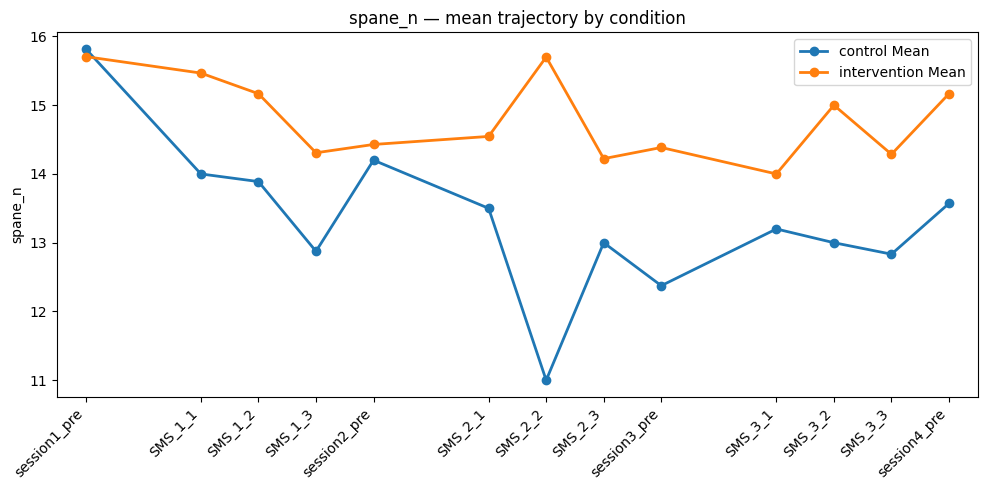

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


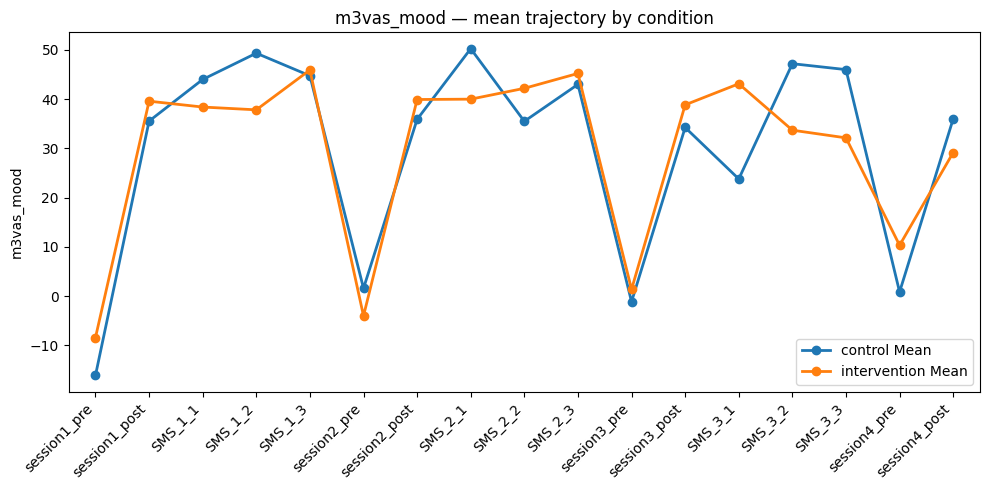

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


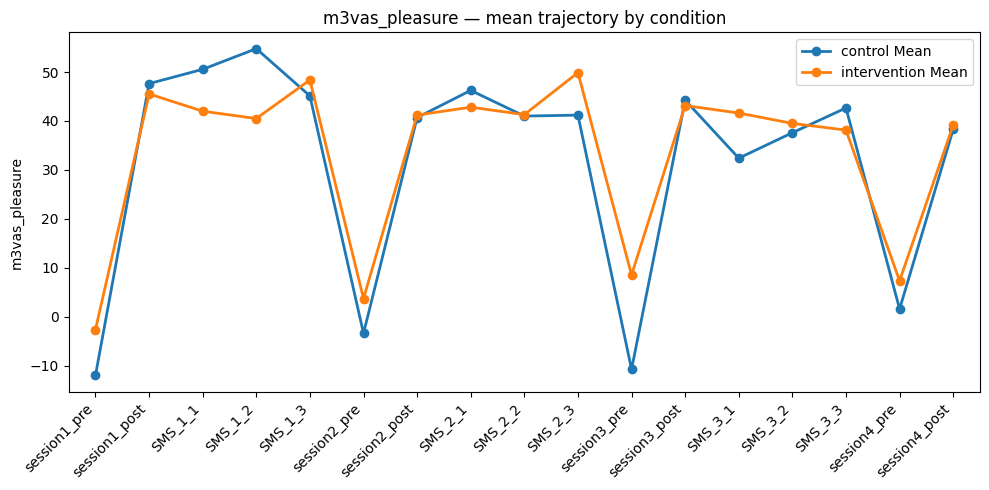

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


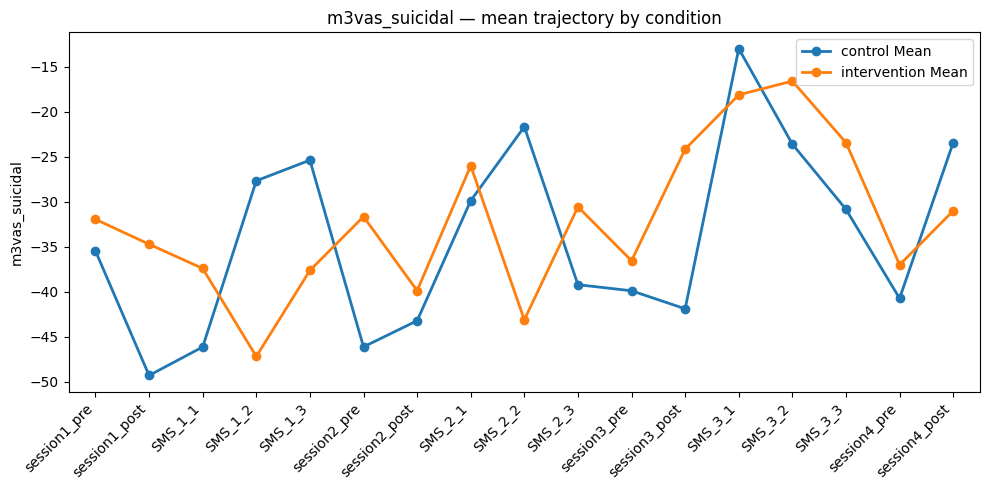

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


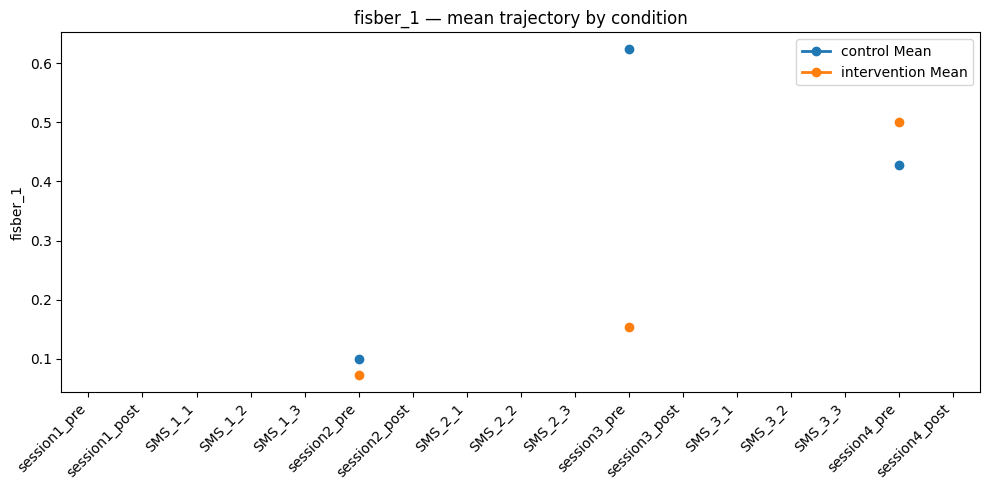

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


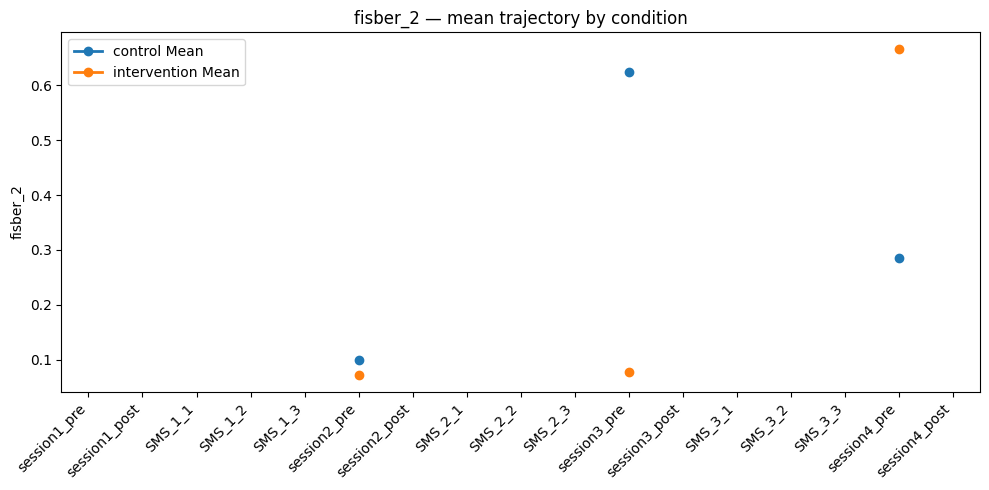

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


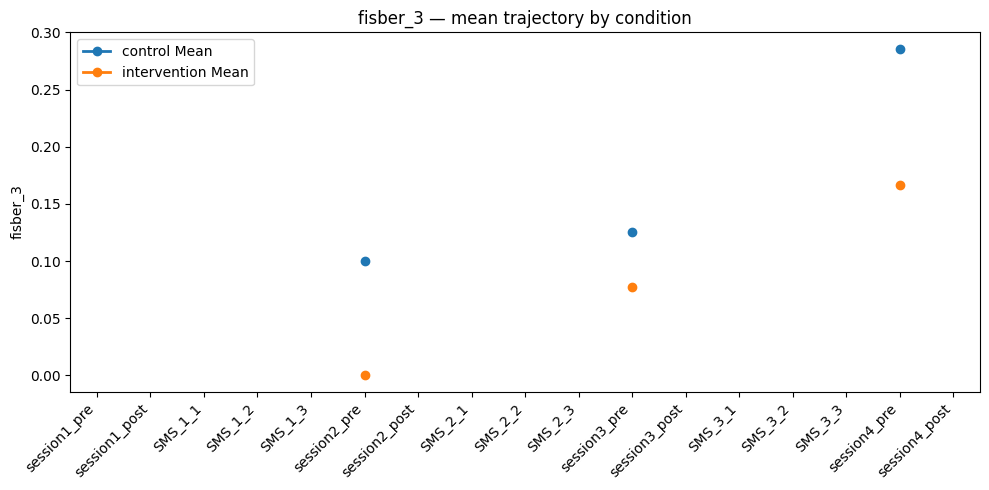

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


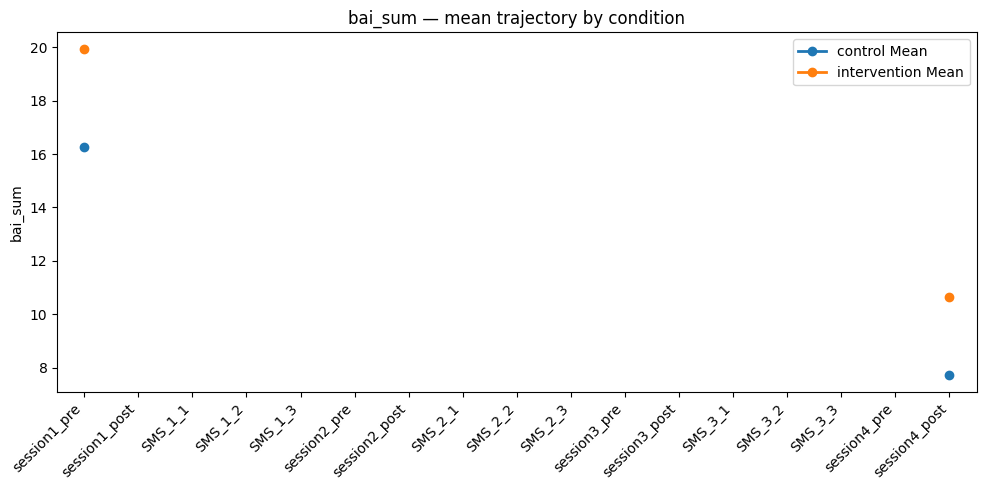

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


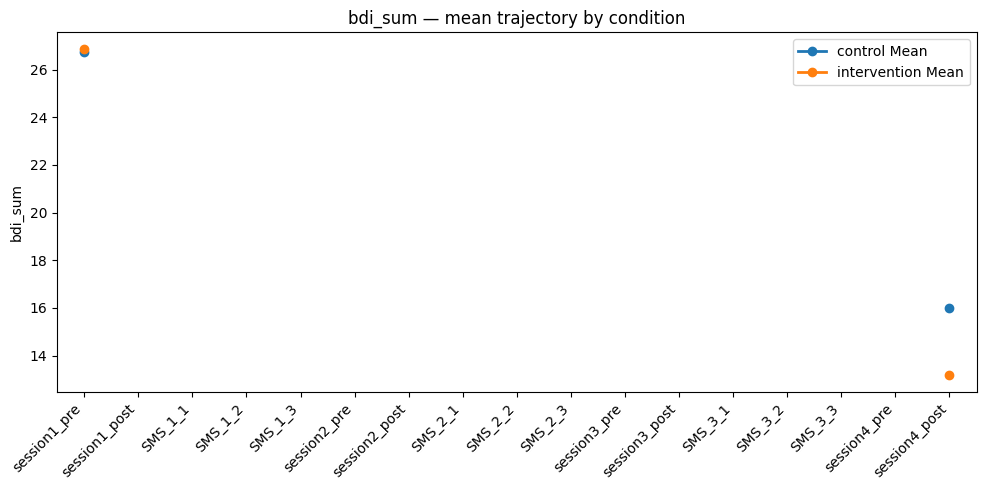

/tmp/ipython-input-27-2742112946.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


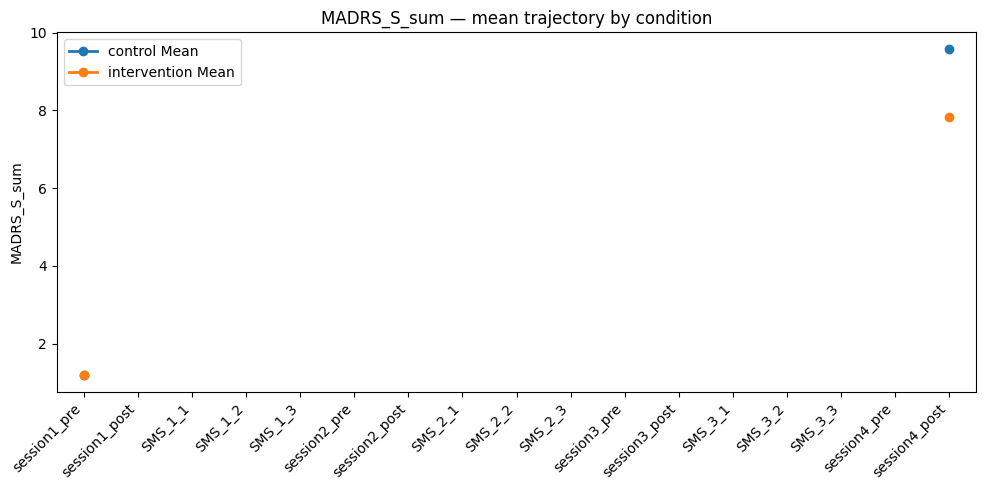

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_mean_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Filter out session*_post for PHQ-9 & SPANE
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, in order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp:i for i,tp in enumerate(ordered_timepoints)}

    # 3) Compute mean (and SEM, if you like) by condition
    mean_df = (
        df_plot
        .groupby(['timepoint','condition'])[measure]
        .mean()
        .unstack('condition')
        .reindex(timepoints_present)
    )
    # sem_df = df_plot.groupby(['timepoint','condition'])[measure].sem().unstack('condition').reindex(timepoints_present)

    # 4) Plot
    fig, ax = plt.subplots(figsize=(10,5))
    for cond in mean_df.columns:
        ax.plot(
            [code_map[tp] for tp in mean_df.index],
            mean_df[cond],
            marker='o', lw=2, label=f"{cond} Mean"
        )
        # To add error bars, uncomment:
        # eb = sem_df[cond]
        # ax.errorbar(
        #     [code_map[tp] for tp in mean_df.index],
        #     mean_df[cond], yerr=eb, fmt='none', capsize=3
        # )

    # 5) Ticks & labels
    locs  = [code_map[tp] for tp in timepoints_present]
    labs  = timepoints_present
    ax.set_xticks(locs)
    ax.set_xticklabels(labs, rotation=45, ha='right')
    ax.set_xlim(min(locs)-0.5, max(locs)+0.5)

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — mean trajectory by condition")
    ax.legend()
    plt.tight_layout()
    plt.show()

# RUN FOR ALL MEASURES
for m in measures:
    plot_mean_by_condition(m)